In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from skimage.morphology import dilation, square 
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.lib import utils
from src.lib import cell_blobs_skimage as blobsutils

In [2]:
def plot_ft_importance(ft_importance, columns):
    fig, ax = plt.subplots(1, figsize=(len(columns)*0.5,  6))
    cmap = cm.YlOrRd
    idx_sorting = ft_importance.argsort()
    sorted_ft_importance = ft_importance[idx_sorting]
    sorted_columns = columns[idx_sorting]

    norm = Normalize(vmin=sorted_ft_importance.min(), vmax=sorted_ft_importance.max())
    ax.bar(sorted_columns, sorted_ft_importance, color=cmap(norm(sorted_ft_importance)))
    ax.set_xticks(sorted_columns)
    ax.set_xticklabels(sorted_columns, rotation=45, ha='right', fontsize=12)
    ax.set_aspect('auto', adjustable='box')

    return fig, ax

In [3]:
df = pd.read_csv('../data/processed/2021-03-29_features.csv', index_col=0)
df.insert(0, 'protein', df.index.str.split("_").str[0])
df.insert(1, 'plate', df.index.str.split("_").str[1])
df.insert(2, 'stimulus', df.index.str.split("_").str[2])
df_negsi = df[(df['protein'] == 'NegsiRNA') & df['stimulus'].isin(['NO', 'NS'])]
X = df_negsi.iloc[:, 3:]
X

white_area_ratio     area_mean      area_std  area_median  \
NegsiRNA_E3_NO          0.297828   9152.662983   5861.016265       8733.0   
NegsiRNA_L2_NS          0.188984  16354.025641  11973.890243      14692.0   
NegsiRNA_H3_NO          0.331324   9066.666667   4624.803328       9137.0   
NegsiRNA_G3_NS          0.239506  12123.135135   6724.839819      11964.0   
NegsiRNA_B1_NO          0.334231   8490.518919   4554.174853       7825.0   
...                          ...           ...           ...          ...   
NegsiRNA_I2_NO          0.294810   9191.983425   6589.745374       8377.0   
NegsiRNA_G3_NO          0.308489  10733.375000   6908.580970       9617.5   
NegsiRNA_A1_NO          0.298644  13177.889831   7140.607112      13257.5   
NegsiRNA_I3_NO          0.287247  10919.454545   7043.811285      10218.0   
NegsiRNA_H3_NS          0.287646   9603.737143   6005.232074       8918.0   

                area_mad  area_mode  perimeter_mean  perimeter_std  \
NegsiRNA_E3_NO    4082.0        324      420.311546     159.207715   
NegsiRNA_L2_NS    7801.0        133      570.751082     272.290111   
NegsiRNA_H3_NO    3065.5       2767      420.014121     125.327416   
NegsiRNA_G3_NS    4811.0      25070      482.741303     162.521925   
NegsiRNA_B1_NO    3243.0       2548      404.229391     126.255607   
...                  ...        ...             ...            ...   
NegsiRNA_I2_NO    4311.0       4017      421.403050     184.206683   
NegsiRNA_G3_NO    4078.5        306      481.153957     177.158340   
NegsiRNA_A1_NO    4826.0       4293      506.398803     170.840229   
NegsiRNA_I3_NO    4508.0        175      466.969360     188.406991   
NegsiRNA_H3_NS    3276.0        183      420.846019     148.258562   

                perimeter_median  perimeter_mad  ...  texture_std_filter_mad  \
NegsiRNA_E3_NO        437.830519     116.509668  ...              380.513855   
NegsiRNA_L2_NS        590.150324     166.775649  ...              338.279541   
NegsiRNA_H3_NO        433.667568      82.961941  ...              699.341797   
NegsiRNA_G3_NS        496.830519     100.961941  ...              437.898560   
NegsiRNA_B1_NO        399.237590      87.865007  ...              444.087952   
...                          ...            ...  ...                     ...   
NegsiRNA_I2_NO        428.475180     126.183766  ...              686.875854   
NegsiRNA_G3_NO        474.140656     112.535534  ...              465.872162   
NegsiRNA_A1_NO        530.445743     114.376154  ...              801.106934   
NegsiRNA_I3_NO        469.747258     116.053824  ...              498.391846   
NegsiRNA_H3_NS        419.954365      90.876154  ...              510.528870   

                texture_std_filter_mode  texture_entropy_filter_mean  \
NegsiRNA_E3_NO               696.241333                     3.656484   
NegsiRNA_L2_NS               625.615723                     3.548006   
NegsiRNA_H3_NO              1050.947021                     4.108348   
NegsiRNA_G3_NS               718.552246                     3.727769   
NegsiRNA_B1_NO               922.306763                     3.842831   
...                                 ...                          ...   
NegsiRNA_I2_NO              1228.524170                     4.171937   
NegsiRNA_G3_NO               900.640015                     3.845423   
NegsiRNA_A1_NO              1262.257812                     4.164838   
NegsiRNA_I3_NO               889.823975                     3.831053   
NegsiRNA_H3_NS               803.342468                     3.914721   

                texture_entropy_filter_std  texture_entropy_filter_median  \
NegsiRNA_E3_NO                    0.564080                       3.654402   
NegsiRNA_L2_NS                    0.576589                       3.554798   
NegsiRNA_H3_NO                    0.547412                       4.139921   
NegsiRNA_G3_NS                    0.585909                       3.736361   
NegsiRNA_B1_NO                    0.532

In [4]:
y = df_negsi['stimulus']
y

NegsiRNA_E3_NO    NO
NegsiRNA_L2_NS    NS
NegsiRNA_H3_NO    NO
NegsiRNA_G3_NS    NS
NegsiRNA_B1_NO    NO
                  ..
NegsiRNA_I2_NO    NO
NegsiRNA_G3_NO    NO
NegsiRNA_A1_NO    NO
NegsiRNA_I3_NO    NO
NegsiRNA_H3_NS    NS
Name: stimulus, Length: 68, dtype: object

### Normalize features

In [5]:
fts2normalize = ["perimeter_borderless_mean", "perimeter_mean", "major_axis_length_mean", "hull_perimeter_mean", "area_borderless_mean", "major_axis_length_borderless_mean", "hull_perimeter_borderless_mean", "hull_area_borderless_mean", "perimeter_median", "major_axis_length_median", "minor_axis_length_mean", "hull_perimeter_median", "area_mean", "minor_axis_length_borderless_mean", "hull_area_mean", "major_axis_length_borderless_median", "area_median", "minor_axis_length_>900_median", "hull_area_median", "hull_perimeter_borderless_median", "hull_area_borderless_median", "area_borderless_median", "perimeter_borderless_median", "minor_axis_length_>900_mean", "hull_perimeter_>900_median", "hull_area_>900_median", "hull_perimeter_>900_mean", "major_axis_length_>900_mean", "major_axis_length_>900_median", "area_>900_median", "minor_axis_length_borderless_median", "minor_axis_length_median"]
print(len(fts2normalize))

32


In [6]:
for ft in fts2normalize:
    X[f'{ft}_normalized'] = X[ft] / X['blobs_borderless_n']
X

white_area_ratio     area_mean      area_std  area_median  \
NegsiRNA_E3_NO          0.297828   9152.662983   5861.016265       8733.0   
NegsiRNA_L2_NS          0.188984  16354.025641  11973.890243      14692.0   
NegsiRNA_H3_NO          0.331324   9066.666667   4624.803328       9137.0   
NegsiRNA_G3_NS          0.239506  12123.135135   6724.839819      11964.0   
NegsiRNA_B1_NO          0.334231   8490.518919   4554.174853       7825.0   
...                          ...           ...           ...          ...   
NegsiRNA_I2_NO          0.294810   9191.983425   6589.745374       8377.0   
NegsiRNA_G3_NO          0.308489  10733.375000   6908.580970       9617.5   
NegsiRNA_A1_NO          0.298644  13177.889831   7140.607112      13257.5   
NegsiRNA_I3_NO          0.287247  10919.454545   7043.811285      10218.0   
NegsiRNA_H3_NS          0.287646   9603.737143   6005.232074       8918.0   

                area_mad  area_mode  perimeter_mean  perimeter_std  \
NegsiRNA_E3_NO    4082.0        324      420.311546     159.207715   
NegsiRNA_L2_NS    7801.0        133      570.751082     272.290111   
NegsiRNA_H3_NO    3065.5       2767      420.014121     125.327416   
NegsiRNA_G3_NS    4811.0      25070      482.741303     162.521925   
NegsiRNA_B1_NO    3243.0       2548      404.229391     126.255607   
...                  ...        ...             ...            ...   
NegsiRNA_I2_NO    4311.0       4017      421.403050     184.206683   
NegsiRNA_G3_NO    4078.5        306      481.153957     177.158340   
NegsiRNA_A1_NO    4826.0       4293      506.398803     170.840229   
NegsiRNA_I3_NO    4508.0        175      466.969360     188.406991   
NegsiRNA_H3_NS    3276.0        183      420.846019     148.258562   

                perimeter_median  perimeter_mad  ...  \
NegsiRNA_E3_NO        437.830519     116.509668  ...   
NegsiRNA_L2_NS        590.150324     166.775649  ...   
NegsiRNA_H3_NO        433.667568      82.961941  ...   
NegsiRNA_G3_NS        496.830519     100.961941  ...   
NegsiRNA_B1_NO        399.237590      87.865007  ...   
...                          ...            ...  ...   
NegsiRNA_I2_NO        428.475180     126.183766  ...   
NegsiRNA_G3_NO        474.140656     112.535534  ...   
NegsiRNA_A1_NO        530.445743     114.376154  ...   
NegsiRNA_I3_NO        469.747258     116.053824  ...   
NegsiRNA_H3_NS        419.954365      90.876154  ...   

                perimeter_borderless_median_normalized  \
NegsiRNA_E3_NO                                3.283352   
NegsiRNA_L2_NS                                7.894984   
NegsiRNA_H3_NO                                3.650859   
NegsiRNA_G3_NS                                4.987905   
NegsiRNA_B1_NO                                2.840701   
...                                                ...   
NegsiRNA_I2_NO                                3.440510   
NegsiRNA_G3_NO                                4.432134   
NegsiRNA_A1_NO                                6.978308   
NegsiRNA_I3_NO                                4.401193   
NegsiRNA_H3_NS                                3.712336   

                minor_axis_length_>900_mean_normalized  \
NegsiRNA_E3_NO                                0.644332   
NegsiRNA_L2_NS                                1.546208   
NegsiRNA_H3_NO                                0.711072   
NegsiRNA_G3_NS                                0.946023   
NegsiRNA_B1_NO                                0.576200   
...                                                ...   
NegsiRNA_I2_NO                                0.666331   
NegsiRNA_G3_NO                                0.838091   
NegsiRNA_A1_NO                                1.322179   
NegsiRNA_I3_NO                                0.861728   
NegsiRNA_H3_NS                                0.750901   

                hull_perimeter_>900_median_normalized  \
NegsiRNA_E3_NO                               2.938138   
NegsiRNA_L2_NS                               7.157941   
NegsiRNA_H3_

In [7]:
X = X.drop(columns=fts2normalize)
X

white_area_ratio      area_std  area_mad  area_mode  \
NegsiRNA_E3_NO          0.297828   5861.016265    4082.0        324   
NegsiRNA_L2_NS          0.188984  11973.890243    7801.0        133   
NegsiRNA_H3_NO          0.331324   4624.803328    3065.5       2767   
NegsiRNA_G3_NS          0.239506   6724.839819    4811.0      25070   
NegsiRNA_B1_NO          0.334231   4554.174853    3243.0       2548   
...                          ...           ...       ...        ...   
NegsiRNA_I2_NO          0.294810   6589.745374    4311.0       4017   
NegsiRNA_G3_NO          0.308489   6908.580970    4078.5        306   
NegsiRNA_A1_NO          0.298644   7140.607112    4826.0       4293   
NegsiRNA_I3_NO          0.287247   7043.811285    4508.0        175   
NegsiRNA_H3_NS          0.287646   6005.232074    3276.0        183   

                perimeter_std  perimeter_mad  perimeter_mode  hull_area_std  \
NegsiRNA_E3_NO     159.207715     116.509668      517.771751    6572.097161   
NegsiRNA_L2_NS     272.290111     166.775649      617.065431   13652.711386   
NegsiRNA_H3_NO     125.327416      82.961941      433.348366    5145.903698   
NegsiRNA_G3_NS     162.521925     100.961941      492.374675    7651.540393   
NegsiRNA_B1_NO     126.255607      87.865007      378.737148    5054.501023   
...                       ...            ...             ...            ...   
NegsiRNA_I2_NO     184.206683     126.183766      568.517878    7683.898273   
NegsiRNA_G3_NO     177.158340     112.535534      438.440335    7826.760716   
NegsiRNA_A1_NO     170.840229     114.376154      523.746765    7869.276798   
NegsiRNA_I3_NO     188.406991     116.053824      511.797105    8238.678171   
NegsiRNA_H3_NS     148.258562      90.876154      389.620560    6677.607827   

                hull_area_mad  hull_area_mode  ...  \
NegsiRNA_E3_NO         4538.0             348  ...   
NegsiRNA_L2_NS         9178.0             145  ...   
NegsiRNA_H3_NO         3361.0            4875  ...   
NegsiRNA_G3_NS         5172.5             150  ...   
NegsiRNA_B1_NO         3698.0            4647  ...   
...                       ...             ...  ...   
NegsiRNA_I2_NO         5374.0             958  ...   
NegsiRNA_G3_NO         4771.0             331  ...   
NegsiRNA_A1_NO         5848.5             141  ...   
NegsiRNA_I3_NO         5205.5             178  ...   
NegsiRNA_H3_NS         3719.0             186  ...   

                perimeter_borderless_median_normalized  \
NegsiRNA_E3_NO                                3.283352   
NegsiRNA_L2_NS                                7.894984   
NegsiRNA_H3_NO                                3.650859   
NegsiRNA_G3_NS                                4.987905   
NegsiRNA_B1_NO                                2.840701   
...                                                ...   
NegsiRNA_I2_NO                                3.440510   
NegsiRNA_G3_NO                                4.432134   
NegsiRNA_A1_NO                                6.978308   
NegsiRNA_I3_NO                                4.401193   
NegsiRNA_H3_NS                                3.712336   

                minor_axis_length_>900_mean_normalized  \
NegsiRNA_E3_NO                                0.644332   
NegsiRNA_L2_NS                                1.546208   
NegsiRNA_H3_NO                                0.711072   
NegsiRNA_G3_NS                                0.946023   
NegsiRNA_B1_NO                                0.576200   
...                                                ...   
NegsiRNA_I2_NO                                0.666331   
NegsiRNA_G3_NO                                0.838091   
NegsiRNA_A1_NO                                1.322179   
NegsiRNA_I3_NO                                0.861728   
NegsiRNA_H3_NS                                0.750901   

                hull_perimeter_>900_median_normalized  \
NegsiRNA_E3_NO                               2.938138   
NegsiRNA_L2_NS                               7.157941   


In [8]:
X = X.drop(columns=['blobs_n', 'blobs_borderless_n', 'blobs_>900_n', 'nuclei_n'])
X

white_area_ratio      area_std  area_mad  area_mode  \
NegsiRNA_E3_NO          0.297828   5861.016265    4082.0        324   
NegsiRNA_L2_NS          0.188984  11973.890243    7801.0        133   
NegsiRNA_H3_NO          0.331324   4624.803328    3065.5       2767   
NegsiRNA_G3_NS          0.239506   6724.839819    4811.0      25070   
NegsiRNA_B1_NO          0.334231   4554.174853    3243.0       2548   
...                          ...           ...       ...        ...   
NegsiRNA_I2_NO          0.294810   6589.745374    4311.0       4017   
NegsiRNA_G3_NO          0.308489   6908.580970    4078.5        306   
NegsiRNA_A1_NO          0.298644   7140.607112    4826.0       4293   
NegsiRNA_I3_NO          0.287247   7043.811285    4508.0        175   
NegsiRNA_H3_NS          0.287646   6005.232074    3276.0        183   

                perimeter_std  perimeter_mad  perimeter_mode  hull_area_std  \
NegsiRNA_E3_NO     159.207715     116.509668      517.771751    6572.097161   
NegsiRNA_L2_NS     272.290111     166.775649      617.065431   13652.711386   
NegsiRNA_H3_NO     125.327416      82.961941      433.348366    5145.903698   
NegsiRNA_G3_NS     162.521925     100.961941      492.374675    7651.540393   
NegsiRNA_B1_NO     126.255607      87.865007      378.737148    5054.501023   
...                       ...            ...             ...            ...   
NegsiRNA_I2_NO     184.206683     126.183766      568.517878    7683.898273   
NegsiRNA_G3_NO     177.158340     112.535534      438.440335    7826.760716   
NegsiRNA_A1_NO     170.840229     114.376154      523.746765    7869.276798   
NegsiRNA_I3_NO     188.406991     116.053824      511.797105    8238.678171   
NegsiRNA_H3_NS     148.258562      90.876154      389.620560    6677.607827   

                hull_area_mad  hull_area_mode  ...  \
NegsiRNA_E3_NO         4538.0             348  ...   
NegsiRNA_L2_NS         9178.0             145  ...   
NegsiRNA_H3_NO         3361.0            4875  ...   
NegsiRNA_G3_NS         5172.5             150  ...   
NegsiRNA_B1_NO         3698.0            4647  ...   
...                       ...             ...  ...   
NegsiRNA_I2_NO         5374.0             958  ...   
NegsiRNA_G3_NO         4771.0             331  ...   
NegsiRNA_A1_NO         5848.5             141  ...   
NegsiRNA_I3_NO         5205.5             178  ...   
NegsiRNA_H3_NS         3719.0             186  ...   

                perimeter_borderless_median_normalized  \
NegsiRNA_E3_NO                                3.283352   
NegsiRNA_L2_NS                                7.894984   
NegsiRNA_H3_NO                                3.650859   
NegsiRNA_G3_NS                                4.987905   
NegsiRNA_B1_NO                                2.840701   
...                                                ...   
NegsiRNA_I2_NO                                3.440510   
NegsiRNA_G3_NO                                4.432134   
NegsiRNA_A1_NO                                6.978308   
NegsiRNA_I3_NO                                4.401193   
NegsiRNA_H3_NS                                3.712336   

                minor_axis_length_>900_mean_normalized  \
NegsiRNA_E3_NO                                0.644332   
NegsiRNA_L2_NS                                1.546208   
NegsiRNA_H3_NO                                0.711072   
NegsiRNA_G3_NS                                0.946023   
NegsiRNA_B1_NO                                0.576200   
...                                                ...   
NegsiRNA_I2_NO                                0.666331   
NegsiRNA_G3_NO                                0.838091   
NegsiRNA_A1_NO                                1.322179   
NegsiRNA_I3_NO                                0.861728   
NegsiRNA_H3_NS                                0.750901   

                hull_perimeter_>900_median_normalized  \
NegsiRNA_E3_NO                               2.938138   
NegsiRNA_L2_NS                               7.157941   


### Remove features with NaN values

In [9]:
has_nan = (X.isna().sum() > 0)
X = X[has_nan[~has_nan].index]
X

white_area_ratio      area_std  area_mad  area_mode  \
NegsiRNA_E3_NO          0.297828   5861.016265    4082.0        324   
NegsiRNA_L2_NS          0.188984  11973.890243    7801.0        133   
NegsiRNA_H3_NO          0.331324   4624.803328    3065.5       2767   
NegsiRNA_G3_NS          0.239506   6724.839819    4811.0      25070   
NegsiRNA_B1_NO          0.334231   4554.174853    3243.0       2548   
...                          ...           ...       ...        ...   
NegsiRNA_I2_NO          0.294810   6589.745374    4311.0       4017   
NegsiRNA_G3_NO          0.308489   6908.580970    4078.5        306   
NegsiRNA_A1_NO          0.298644   7140.607112    4826.0       4293   
NegsiRNA_I3_NO          0.287247   7043.811285    4508.0        175   
NegsiRNA_H3_NS          0.287646   6005.232074    3276.0        183   

                perimeter_std  perimeter_mad  perimeter_mode  hull_area_std  \
NegsiRNA_E3_NO     159.207715     116.509668      517.771751    6572.097161   
NegsiRNA_L2_NS     272.290111     166.775649      617.065431   13652.711386   
NegsiRNA_H3_NO     125.327416      82.961941      433.348366    5145.903698   
NegsiRNA_G3_NS     162.521925     100.961941      492.374675    7651.540393   
NegsiRNA_B1_NO     126.255607      87.865007      378.737148    5054.501023   
...                       ...            ...             ...            ...   
NegsiRNA_I2_NO     184.206683     126.183766      568.517878    7683.898273   
NegsiRNA_G3_NO     177.158340     112.535534      438.440335    7826.760716   
NegsiRNA_A1_NO     170.840229     114.376154      523.746765    7869.276798   
NegsiRNA_I3_NO     188.406991     116.053824      511.797105    8238.678171   
NegsiRNA_H3_NS     148.258562      90.876154      389.620560    6677.607827   

                hull_area_mad  hull_area_mode  ...  \
NegsiRNA_E3_NO         4538.0             348  ...   
NegsiRNA_L2_NS         9178.0             145  ...   
NegsiRNA_H3_NO         3361.0            4875  ...   
NegsiRNA_G3_NS         5172.5             150  ...   
NegsiRNA_B1_NO         3698.0            4647  ...   
...                       ...             ...  ...   
NegsiRNA_I2_NO         5374.0             958  ...   
NegsiRNA_G3_NO         4771.0             331  ...   
NegsiRNA_A1_NO         5848.5             141  ...   
NegsiRNA_I3_NO         5205.5             178  ...   
NegsiRNA_H3_NS         3719.0             186  ...   

                perimeter_borderless_median_normalized  \
NegsiRNA_E3_NO                                3.283352   
NegsiRNA_L2_NS                                7.894984   
NegsiRNA_H3_NO                                3.650859   
NegsiRNA_G3_NS                                4.987905   
NegsiRNA_B1_NO                                2.840701   
...                                                ...   
NegsiRNA_I2_NO                                3.440510   
NegsiRNA_G3_NO                                4.432134   
NegsiRNA_A1_NO                                6.978308   
NegsiRNA_I3_NO                                4.401193   
NegsiRNA_H3_NS                                3.712336   

                minor_axis_length_>900_mean_normalized  \
NegsiRNA_E3_NO                                0.644332   
NegsiRNA_L2_NS                                1.546208   
NegsiRNA_H3_NO                                0.711072   
NegsiRNA_G3_NS                                0.946023   
NegsiRNA_B1_NO                                0.576200   
...                                                ...   
NegsiRNA_I2_NO                                0.666331   
NegsiRNA_G3_NO                                0.838091   
NegsiRNA_A1_NO                                1.322179   
NegsiRNA_I3_NO                                0.861728   
NegsiRNA_H3_NS                                0.750901   

                hull_perimeter_>900_median_normalized  \
NegsiRNA_E3_NO                               2.938138   
NegsiRNA_L2_NS                               7.157941   


In [10]:
print(f"Removed {len(has_nan[has_nan])} features with NaN values: {', '.join(has_nan[has_nan].index)}")

Removed 3 features with NaN values: e2e_distance_std, e2e_eu_distance_std, e2e_distance_ratio_std


Looking into the features that were removed, we can see that all of them are standard deviations for length measures of a specific kind of skeleton branch (end to end, _e2e_). Those features had NaN values, which means that there are not enough values to compute the standard deviation. Looking deeper into those measures, we realized that the number of branches of that kind is really small (< 12) for all the samples, so we decided to remove all the features related to that kind of branch.

In [11]:
e2e_cols = [col for col in X.columns if col.startswith('e2e')]
X = X.drop(columns=e2e_cols)
print(f"Removed {len(e2e_cols)} e2e branch features: {', '.join(e2e_cols)}")

Removed 13 e2e branch features: e2e_n, e2e_distance_mean, e2e_distance_median, e2e_distance_mad, e2e_distance_mode, e2e_eu_distance_mean, e2e_eu_distance_median, e2e_eu_distance_mad, e2e_eu_distance_mode, e2e_distance_ratio_mean, e2e_distance_ratio_median, e2e_distance_ratio_mad, e2e_distance_ratio_mode


### Remove features with constant value

In [12]:
vt_selector = VarianceThreshold()
vt_selector.fit(X)
selected = vt_selector.get_support()
non_selected_names = X.columns[np.where(~selected)[0]]
X = X.iloc[:, np.where(selected)[0]]
X

white_area_ratio      area_std  area_mad  area_mode  \
NegsiRNA_E3_NO          0.297828   5861.016265    4082.0        324   
NegsiRNA_L2_NS          0.188984  11973.890243    7801.0        133   
NegsiRNA_H3_NO          0.331324   4624.803328    3065.5       2767   
NegsiRNA_G3_NS          0.239506   6724.839819    4811.0      25070   
NegsiRNA_B1_NO          0.334231   4554.174853    3243.0       2548   
...                          ...           ...       ...        ...   
NegsiRNA_I2_NO          0.294810   6589.745374    4311.0       4017   
NegsiRNA_G3_NO          0.308489   6908.580970    4078.5        306   
NegsiRNA_A1_NO          0.298644   7140.607112    4826.0       4293   
NegsiRNA_I3_NO          0.287247   7043.811285    4508.0        175   
NegsiRNA_H3_NS          0.287646   6005.232074    3276.0        183   

                perimeter_std  perimeter_mad  perimeter_mode  hull_area_std  \
NegsiRNA_E3_NO     159.207715     116.509668      517.771751    6572.097161   
NegsiRNA_L2_NS     272.290111     166.775649      617.065431   13652.711386   
NegsiRNA_H3_NO     125.327416      82.961941      433.348366    5145.903698   
NegsiRNA_G3_NS     162.521925     100.961941      492.374675    7651.540393   
NegsiRNA_B1_NO     126.255607      87.865007      378.737148    5054.501023   
...                       ...            ...             ...            ...   
NegsiRNA_I2_NO     184.206683     126.183766      568.517878    7683.898273   
NegsiRNA_G3_NO     177.158340     112.535534      438.440335    7826.760716   
NegsiRNA_A1_NO     170.840229     114.376154      523.746765    7869.276798   
NegsiRNA_I3_NO     188.406991     116.053824      511.797105    8238.678171   
NegsiRNA_H3_NS     148.258562      90.876154      389.620560    6677.607827   

                hull_area_mad  hull_area_mode  ...  \
NegsiRNA_E3_NO         4538.0             348  ...   
NegsiRNA_L2_NS         9178.0             145  ...   
NegsiRNA_H3_NO         3361.0            4875  ...   
NegsiRNA_G3_NS         5172.5             150  ...   
NegsiRNA_B1_NO         3698.0            4647  ...   
...                       ...             ...  ...   
NegsiRNA_I2_NO         5374.0             958  ...   
NegsiRNA_G3_NO         4771.0             331  ...   
NegsiRNA_A1_NO         5848.5             141  ...   
NegsiRNA_I3_NO         5205.5             178  ...   
NegsiRNA_H3_NS         3719.0             186  ...   

                perimeter_borderless_median_normalized  \
NegsiRNA_E3_NO                                3.283352   
NegsiRNA_L2_NS                                7.894984   
NegsiRNA_H3_NO                                3.650859   
NegsiRNA_G3_NS                                4.987905   
NegsiRNA_B1_NO                                2.840701   
...                                                ...   
NegsiRNA_I2_NO                                3.440510   
NegsiRNA_G3_NO                                4.432134   
NegsiRNA_A1_NO                                6.978308   
NegsiRNA_I3_NO                                4.401193   
NegsiRNA_H3_NS                                3.712336   

                minor_axis_length_>900_mean_normalized  \
NegsiRNA_E3_NO                                0.644332   
NegsiRNA_L2_NS                                1.546208   
NegsiRNA_H3_NO                                0.711072   
NegsiRNA_G3_NS                                0.946023   
NegsiRNA_B1_NO                                0.576200   
...                                                ...   
NegsiRNA_I2_NO                                0.666331   
NegsiRNA_G3_NO                                0.838091   
NegsiRNA_A1_NO                                1.322179   
NegsiRNA_I3_NO                                0.861728   
NegsiRNA_H3_NS                                0.750901   

                hull_perimeter_>900_median_normalized  \
NegsiRNA_E3_NO                               2.938138   
NegsiRNA_L2_NS                               7.157941   


In [13]:
print(f"Removed {len(np.where(~selected)[0])} features with constant values: {', '.join(non_selected_names)}")

Removed 3 features with constant values: nodes_median, nodes_mad, nodes_mode


The three features that were removed are related to the degree of the nodes (vertices). We should look further into it, so we are going to analyze the variability of the remaining node features.

In [14]:
X[(col for col in X.columns if col.startswith('nodes'))].describe()

nodes_n  nodes_max  nodes_mean  nodes_std
count    68.000000  68.000000   68.000000  68.000000
mean   1813.941176   5.058824    3.130788   0.344417
std     290.680770   0.381762    0.011429   0.017567
min     998.000000   4.000000    3.099608   0.299476
25%    1636.750000   5.000000    3.124607   0.336184
50%    1805.000000   5.000000    3.127972   0.341051
75%    1973.750000   5.000000    3.137634   0.352765
max    2556.000000   6.000000    3.186493   0.439495

All those features are almost constant, except nodes_n. So we are removing those features.

In [15]:
nodes_cols = ['nodes_max', 'nodes_mean', 'nodes_std']
X = X.drop(columns=nodes_cols)
print(f"Removed {len(nodes_cols)} e2e branch features: {', '.join(nodes_cols)}")

Removed 3 e2e branch features: nodes_max, nodes_mean, nodes_std


In [16]:
cols2drop = [col for col in X.columns if col.split("_")[-1] in ['mean', 'std', 'mad', 'mode']]
cols2drop += [col for col in X.columns if '_'.join(col.split("_")[-2:]) in ['mean_normalized', 'std_normalized', 'mad_normalized', 'mode_normalized']]
print(cols2drop)
X = X.drop(columns=cols2drop)

['area_std', 'area_mad', 'area_mode', 'perimeter_std', 'perimeter_mad', 'perimeter_mode', 'hull_area_std', 'hull_area_mad', 'hull_area_mode', 'hull_perimeter_std', 'hull_perimeter_mad', 'hull_perimeter_mode', 'compactness_mean', 'compactness_std', 'compactness_mad', 'compactness_mode', 'solidity_mean', 'solidity_std', 'solidity_mad', 'solidity_mode', 'convexity_mean', 'convexity_std', 'convexity_mad', 'convexity_mode', 'major_axis_length_std', 'major_axis_length_mad', 'major_axis_length_mode', 'minor_axis_length_std', 'minor_axis_length_mad', 'minor_axis_length_mode', 'elongation_mean', 'elongation_std', 'elongation_mad', 'elongation_mode', 'area_borderless_std', 'area_borderless_mad', 'area_borderless_mode', 'perimeter_borderless_std', 'perimeter_borderless_mad', 'perimeter_borderless_mode', 'hull_area_borderless_std', 'hull_area_borderless_mad', 'hull_area_borderless_mode', 'hull_perimeter_borderless_std', 'hull_perimeter_borderless_mad', 'hull_perimeter_borderless_mode', 'compactnes

In [17]:
X

white_area_ratio  compactness_median  solidity_median  \
NegsiRNA_E3_NO          0.297828            0.613938         0.919441   
NegsiRNA_L2_NS          0.188984            0.574243         0.908038   
NegsiRNA_H3_NO          0.331324            0.614409         0.918018   
NegsiRNA_G3_NS          0.239506            0.616320         0.924107   
NegsiRNA_B1_NO          0.334231            0.651737         0.924544   
...                          ...                 ...              ...   
NegsiRNA_I2_NO          0.294810            0.590679         0.909091   
NegsiRNA_G3_NO          0.308489            0.552337         0.905983   
NegsiRNA_A1_NO          0.298644            0.608864         0.923012   
NegsiRNA_I3_NO          0.287247            0.594003         0.913212   
NegsiRNA_H3_NS          0.287646            0.640273         0.926298   

                convexity_median  elongation_median  \
NegsiRNA_E3_NO          0.933102           1.490996   
NegsiRNA_L2_NS          0.924152           1.564275   
NegsiRNA_H3_NO          0.945185           1.522873   
NegsiRNA_G3_NS          0.953916           1.605516   
NegsiRNA_B1_NO          0.953457           1.566899   
...                          ...                ...   
NegsiRNA_I2_NO          0.941260           1.608352   
NegsiRNA_G3_NO          0.920725           1.688006   
NegsiRNA_A1_NO          0.938238           1.549009   
NegsiRNA_I3_NO          0.940686           1.594342   
NegsiRNA_H3_NS          0.954759           1.560488   

                compactness_borderless_median  solidity_borderless_median  \
NegsiRNA_E3_NO                       0.614781                    0.916856   
NegsiRNA_L2_NS                       0.584323                    0.907328   
NegsiRNA_H3_NO                       0.616945                    0.915551   
NegsiRNA_G3_NS                       0.612040                    0.911647   
NegsiRNA_B1_NO                       0.657768                    0.923943   
...                                       ...                         ...   
NegsiRNA_I2_NO                       0.594939                    0.898833   
NegsiRNA_G3_NO                       0.571916                    0.902606   
NegsiRNA_A1_NO                       0.612168                    0.923243   
NegsiRNA_I3_NO                       0.596716                    0.912197   
NegsiRNA_H3_NS                       0.662541                    0.927335   

                convexity_borderless_median  elongation_borderless_median  \
NegsiRNA_E3_NO                     0.927603                      1.448576   
NegsiRNA_L2_NS                     0.925205                      1.523195   
NegsiRNA_H3_NO                     0.937294                      1.472948   
NegsiRNA_G3_NS                     0.944047                      1.521927   
NegsiRNA_B1_NO                     0.951059                      1.501067   
...                                     ...                           ...   
NegsiRNA_I2_NO                     0.934052                      1.565276   
NegsiRNA_G3_NO                     0.910640                      1.589326   
NegsiRNA_A1_NO                     0.924468                      1.544299   
NegsiRNA_I3_NO                     0.929273                      1.571240   
NegsiRNA_H3_NS                     0.950238                      1.493704   

                perimeter_>900_median  ...  \
NegsiRNA_E3_NO             446.090404  ...   
NegsiRNA_L2_NS             606.055916  ...   
NegsiRNA_H3_NO             437.521861  ...   
NegsiRNA_G3_NS             500.537626  ...   
NegsiRNA_B1_NO             401.921356  ...   
...                               ...  ...   
NegsiRNA_I2_NO             448.575685  ...   
NegsiRNA_G3_NO             476.223917  ...   
NegsiRNA_A1_NO             533.839141  ...   
NegsiRNA_I3_NO             478.312229  ...   
NegsiRNA_H3_NS             438.717821  ...   

                hull_perimeter_borderless_median_normalized  \
NegsiRNA_E3_

### Remove features based on mutual information and F-score

In [18]:
blobs_features = ['area', 'perimeter', 'hull_area', 'hull_perimeter', 'compactness', 'solidity', 'convexity', 'major_axis_length', 'minor_axis_length', 'elongation']

In [19]:
blobs_cols = [col for col in X.columns if col.startswith(tuple(blobs_features)) and 'borderless' not in col and '>900' not in col]
blobs_cols, len(blobs_cols)

(['compactness_median',
  'solidity_median',
  'convexity_median',
  'elongation_median',
  'perimeter_median_normalized',
  'major_axis_length_median_normalized',
  'hull_perimeter_median_normalized',
  'area_median_normalized',
  'hull_area_median_normalized',
  'minor_axis_length_median_normalized'],
 10)

In [20]:
blobs_borderless_cols = [col for col in X.columns if col.startswith(tuple(blobs_features)) and 'borderless' in col]
blobs_borderless_cols, len(blobs_cols)

(['compactness_borderless_median',
  'solidity_borderless_median',
  'convexity_borderless_median',
  'elongation_borderless_median',
  'major_axis_length_borderless_median_normalized',
  'hull_perimeter_borderless_median_normalized',
  'hull_area_borderless_median_normalized',
  'area_borderless_median_normalized',
  'perimeter_borderless_median_normalized',
  'minor_axis_length_borderless_median_normalized'],
 10)

In [21]:
blobs_no_small_cols = [col for col in X.columns if col.startswith(tuple(blobs_features)) and '>900' in col]
blobs_no_small_cols, len(blobs_no_small_cols)

(['perimeter_>900_median',
  'compactness_>900_median',
  'solidity_>900_median',
  'convexity_>900_median',
  'elongation_>900_median',
  'minor_axis_length_>900_median_normalized',
  'hull_perimeter_>900_median_normalized',
  'hull_area_>900_median_normalized',
  'major_axis_length_>900_median_normalized',
  'area_>900_median_normalized'],
 10)

In [22]:
rest_cols = [col for col in X.columns if not col.startswith(tuple(blobs_features))]
rest_cols, len(rest_cols)

(['white_area_ratio',
  'j2e_n',
  'j2e_distance_median',
  'j2e_eu_distance_median',
  'j2e_distance_ratio_median',
  'j2j_n',
  'j2j_distance_median',
  'j2j_eu_distance_median',
  'j2j_distance_ratio_median',
  'nodes_n',
  'nuclei_blobs_ratio',
  'blobs_<1000_ratio',
  'total_area_blobs<1000',
  'total_area_blobs>70000',
  'percentage_area_blobs<1000',
  'percentage_area_blobs>70000',
  'branch_thickness_medial_axis_median',
  'branch_thickness_voronoi_median',
  'texture_std_filter_median',
  'texture_entropy_filter_median',
  'global_entropy_discrete',
  'global_entropy_kde',
  'global_coeff_var'],
 23)

In [23]:
X_all = X[blobs_cols + rest_cols]
X_all

compactness_median  solidity_median  convexity_median  \
NegsiRNA_E3_NO            0.613938         0.919441          0.933102   
NegsiRNA_L2_NS            0.574243         0.908038          0.924152   
NegsiRNA_H3_NO            0.614409         0.918018          0.945185   
NegsiRNA_G3_NS            0.616320         0.924107          0.953916   
NegsiRNA_B1_NO            0.651737         0.924544          0.953457   
...                            ...              ...               ...   
NegsiRNA_I2_NO            0.590679         0.909091          0.941260   
NegsiRNA_G3_NO            0.552337         0.905983          0.920725   
NegsiRNA_A1_NO            0.608864         0.923012          0.938238   
NegsiRNA_I3_NO            0.594003         0.913212          0.940686   
NegsiRNA_H3_NS            0.640273         0.926298          0.954759   

                elongation_median  perimeter_median_normalized  \
NegsiRNA_E3_NO           1.490996                     3.172685   
NegsiRNA_L2_NS           1.564275                     7.664290   
NegsiRNA_H3_NO           1.522873                     3.469341   
NegsiRNA_G3_NS           1.605516                     4.731719   
NegsiRNA_B1_NO           1.566899                     2.772483   
...                           ...                          ...   
NegsiRNA_I2_NO           1.608352                     3.221618   
NegsiRNA_G3_NO           1.688006                     4.349914   
NegsiRNA_A1_NO           1.549009                     6.714503   
NegsiRNA_I3_NO           1.594342                     4.309608   
NegsiRNA_H3_NS           1.560488                     3.414263   

                major_axis_length_median_normalized  \
NegsiRNA_E3_NO                             0.967823   
NegsiRNA_L2_NS                             2.365398   
NegsiRNA_H3_NO                             1.079493   
NegsiRNA_G3_NS                             1.543705   
NegsiRNA_B1_NO                             0.929113   
...                                             ...   
NegsiRNA_I2_NO                             1.030419   
NegsiRNA_G3_NO                             1.413617   
NegsiRNA_A1_NO                             2.075047   
NegsiRNA_I3_NO                             1.365671   
NegsiRNA_H3_NS                             1.148496   

                hull_perimeter_median_normalized  area_median_normalized  \
NegsiRNA_E3_NO                          2.882955               63.282609   
NegsiRNA_L2_NS                          6.740828              190.805195   
NegsiRNA_H3_NO                          3.230851               73.096000   
NegsiRNA_G3_NS                          4.465812              113.942857   
NegsiRNA_B1_NO                          2.646666               54.340278   
...                                          ...                     ...   
NegsiRNA_I2_NO                          2.994230               62.984962   
NegsiRNA_G3_NO                          3.970778               88.233945   
NegsiRNA_A1_NO                          6.234281              167.816456   
NegsiRNA_I3_NO                          3.995185               93.743119   
NegsiRNA_H3_NS                          3.220247               72.504065   

                hull_area_median_normalized  \
NegsiRNA_E3_NO                    71.913043   
NegsiRNA_L2_NS                   218.480519   
NegsiRNA_H3_NO                    81.048000   
NegsiRNA_G3_NS                   129.271429   
NegsiRNA_B1_NO                    60.534722   
...                                     ...   
NegsiRNA_I2_NO                    72.165414   
NegsiRNA_G3_NO                   100.669725   
NegsiRNA_A1_NO                   188.677215   
NegsiRNA_I3_NO                   103.733945   
NegsiRNA_H3_NS                    80.642276   

                minor_axis_length_median_normalized  ...  \
NegsiRNA_E3_NO                             0.623268  ...   
NegsiRNA_L2_NS                             1.446897  ...   
NegsiRNA_H3_NO             

In [24]:
X_borderless = X[blobs_borderless_cols + rest_cols]
X_borderless

compactness_borderless_median  solidity_borderless_median  \
NegsiRNA_E3_NO                       0.614781                    0.916856   
NegsiRNA_L2_NS                       0.584323                    0.907328   
NegsiRNA_H3_NO                       0.616945                    0.915551   
NegsiRNA_G3_NS                       0.612040                    0.911647   
NegsiRNA_B1_NO                       0.657768                    0.923943   
...                                       ...                         ...   
NegsiRNA_I2_NO                       0.594939                    0.898833   
NegsiRNA_G3_NO                       0.571916                    0.902606   
NegsiRNA_A1_NO                       0.612168                    0.923243   
NegsiRNA_I3_NO                       0.596716                    0.912197   
NegsiRNA_H3_NS                       0.662541                    0.927335   

                convexity_borderless_median  elongation_borderless_median  \
NegsiRNA_E3_NO                     0.927603                      1.448576   
NegsiRNA_L2_NS                     0.925205                      1.523195   
NegsiRNA_H3_NO                     0.937294                      1.472948   
NegsiRNA_G3_NS                     0.944047                      1.521927   
NegsiRNA_B1_NO                     0.951059                      1.501067   
...                                     ...                           ...   
NegsiRNA_I2_NO                     0.934052                      1.565276   
NegsiRNA_G3_NO                     0.910640                      1.589326   
NegsiRNA_A1_NO                     0.924468                      1.544299   
NegsiRNA_I3_NO                     0.929273                      1.571240   
NegsiRNA_H3_NS                     0.950238                      1.493704   

                major_axis_length_borderless_median_normalized  \
NegsiRNA_E3_NO                                        1.005532   
NegsiRNA_L2_NS                                        2.556302   
NegsiRNA_H3_NO                                        1.127852   
NegsiRNA_G3_NS                                        1.609281   
NegsiRNA_B1_NO                                        0.935628   
...                                                        ...   
NegsiRNA_I2_NO                                        1.098767   
NegsiRNA_G3_NO                                        1.426310   
NegsiRNA_A1_NO                                        2.157486   
NegsiRNA_I3_NO                                        1.411867   
NegsiRNA_H3_NS                                        1.178750   

                hull_perimeter_borderless_median_normalized  \
NegsiRNA_E3_NO                                     3.011418   
NegsiRNA_L2_NS                                     7.376585   
NegsiRNA_H3_NO                                     3.375919   
NegsiRNA_G3_NS                                     4.731042   
NegsiRNA_B1_NO                                     2.718578   
...                                                     ...   
NegsiRNA_I2_NO                                     3.187894   
NegsiRNA_G3_NO                                     4.092256   
NegsiRNA_A1_NO                                     6.378655   
NegsiRNA_I3_NO                                     4.029768   
NegsiRNA_H3_NS                                     3.460204   

                hull_area_borderless_median_normalized  \
NegsiRNA_E3_NO                               77.699275   
NegsiRNA_L2_NS                              261.922078   
NegsiRNA_H3_NO                               90.040000   
NegsiRNA_G3_NS                              146.123810   
NegsiRNA_B1_NO                               66.222222   
...                                                ...   
NegsiRNA_I2_NO                               81.909774   
NegsiRNA_G3_NO                              111.119266   
NegsiRNA_A1_NO                              202.746835   
NegsiRNA_I3_NO                      

In [25]:
X_no_small = X[blobs_no_small_cols + rest_cols]
X_no_small

perimeter_>900_median  compactness_>900_median  \
NegsiRNA_E3_NO             446.090404                 0.613938   
NegsiRNA_L2_NS             606.055916                 0.561652   
NegsiRNA_H3_NO             437.521861                 0.616366   
NegsiRNA_G3_NS             500.537626                 0.615420   
NegsiRNA_B1_NO             401.921356                 0.647550   
...                               ...                      ...   
NegsiRNA_I2_NO             448.575685                 0.590679   
NegsiRNA_G3_NO             476.223917                 0.548285   
NegsiRNA_A1_NO             533.839141                 0.608864   
NegsiRNA_I3_NO             478.312229                 0.594003   
NegsiRNA_H3_NS             438.717821                 0.648787   

                solidity_>900_median  convexity_>900_median  \
NegsiRNA_E3_NO              0.918919               0.931363   
NegsiRNA_L2_NS              0.905397               0.917584   
NegsiRNA_H3_NO              0.917669               0.944182   
NegsiRNA_G3_NS              0.919699               0.952732   
NegsiRNA_B1_NO              0.922162               0.953071   
...                              ...                    ...   
NegsiRNA_I2_NO              0.906132               0.936429   
NegsiRNA_G3_NO              0.904340               0.916676   
NegsiRNA_A1_NO              0.923012               0.938226   
NegsiRNA_I3_NO              0.913006               0.937729   
NegsiRNA_H3_NS              0.927382               0.952142   

                elongation_>900_median  \
NegsiRNA_E3_NO                1.486554   
NegsiRNA_L2_NS                1.564275   
NegsiRNA_H3_NO                1.520332   
NegsiRNA_G3_NS                1.601451   
NegsiRNA_B1_NO                1.574350   
...                                ...   
NegsiRNA_I2_NO                1.587097   
NegsiRNA_G3_NO                1.686579   
NegsiRNA_A1_NO                1.549009   
NegsiRNA_I3_NO                1.589158   
NegsiRNA_H3_NS                1.529688   

                minor_axis_length_>900_median_normalized  \
NegsiRNA_E3_NO                                  0.649420   
NegsiRNA_L2_NS                                  1.527963   
NegsiRNA_H3_NO                                  0.727036   
NegsiRNA_G3_NS                                  1.002525   
NegsiRNA_B1_NO                                  0.580027   
...                                                  ...   
NegsiRNA_I2_NO                                  0.663538   
NegsiRNA_G3_NO                                  0.822321   
NegsiRNA_A1_NO                                  1.384021   
NegsiRNA_I3_NO                                  0.861597   
NegsiRNA_H3_NS                                  0.722590   

                hull_perimeter_>900_median_normalized  \
NegsiRNA_E3_NO                               2.938138   
NegsiRNA_L2_NS                               7.157941   
NegsiRNA_H3_NO                               3.241901   
NegsiRNA_G3_NS                               4.501712   
NegsiRNA_B1_NO                               2.667005   
...                                               ...   
NegsiRNA_I2_NO                               3.097668   
NegsiRNA_G3_NO                               4.003055   
NegsiRNA_A1_NO                               6.248102   
NegsiRNA_I3_NO                               4.038370   
NegsiRNA_H3_NS                               3.349581   

                hull_area_>900_median_normalized  \
NegsiRNA_E3_NO                         73.405797   
NegsiRNA_L2_NS                        232.064935   
NegsiRNA_H3_NO                         81.840000   
NegsiRNA_G3_NS                        131.409524   
NegsiRNA_B1_NO                         62.270833   
...                                          ...   
NegsiRNA_I2_NO                         76.939850   
NegsiRNA_G3_NO                        103.197248   
NegsiRNA_A1_NO                        195.246835   
NegsiRNA_I3_NO                     

              precision    recall  f1-score   support

          NO       0.82      0.91      0.86        34
          NS       0.90      0.79      0.84        34

    accuracy                           0.85        68
   macro avg       0.86      0.85      0.85        68
weighted avg       0.86      0.85      0.85        68



(<Figure size 1188x432 with 1 Axes>, <AxesSubplot:>)

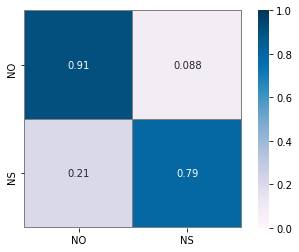

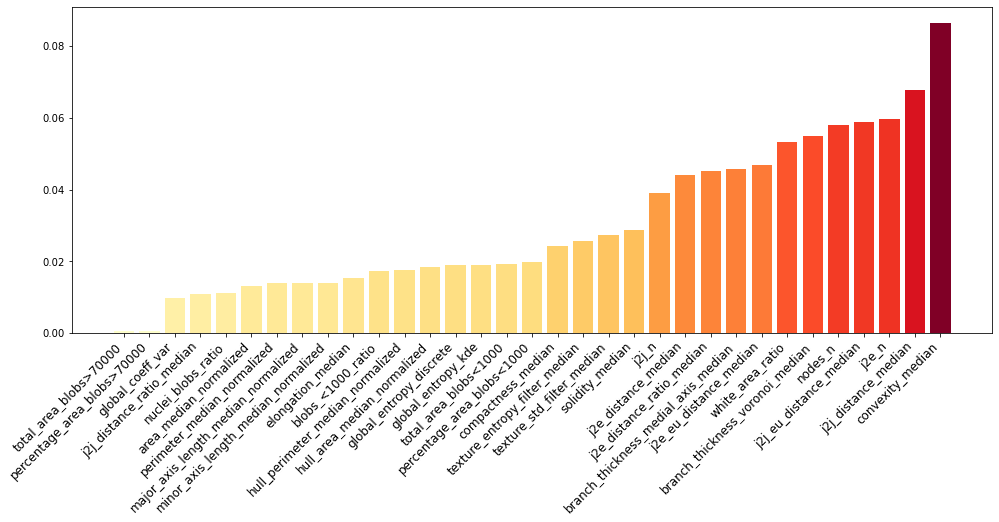

In [26]:
current_data = X_all
clf = RandomForestClassifier(oob_score=True, max_features="sqrt", n_estimators=2000, random_state=0)
clf.fit(current_data, y)

predicted_index = clf.oob_decision_function_.argmax(axis=1)
predicted = np.array(list(clf.classes_[i] for i in predicted_index))
print(classification_report(y, predicted))

cmx = confusion_matrix(y, predicted, labels=clf.classes_)
cmx_norm = cmx / cmx.sum(axis=1)[:, np.newaxis]
cmx_df = pd.DataFrame(cmx_norm, index=clf.classes_, columns=clf.classes_)
sns.heatmap(cmx_df, square=True, cmap='PuBu', annot=True, linewidths=0.1, linecolor='gray', vmin=0, vmax=1)

plot_ft_importance(clf.feature_importances_, current_data.columns)

              precision    recall  f1-score   support

          NO       0.81      0.88      0.85        34
          NS       0.87      0.79      0.83        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68



(<Figure size 1188x432 with 1 Axes>, <AxesSubplot:>)

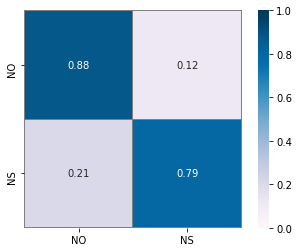

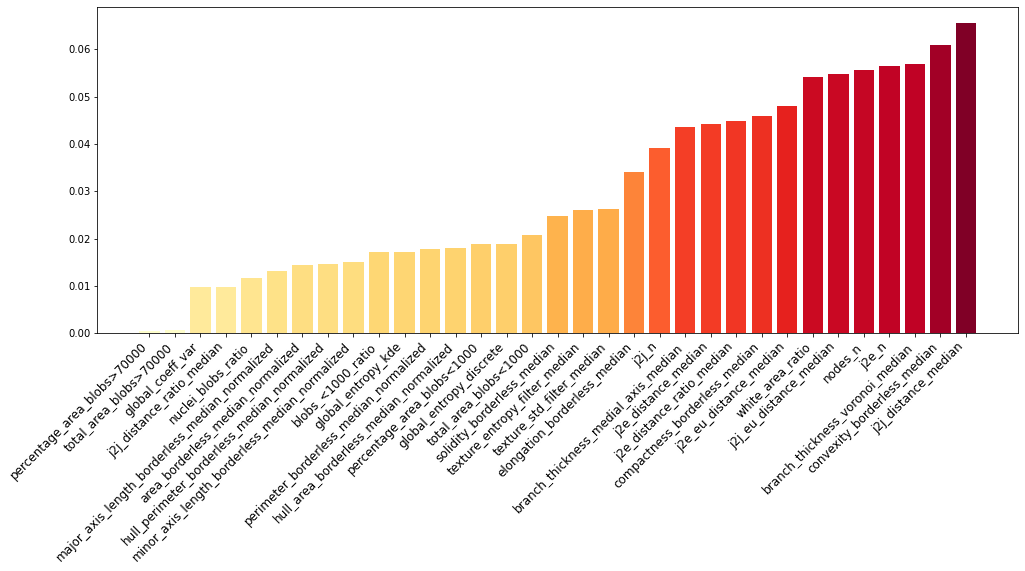

In [27]:
current_data = X_borderless
clf = RandomForestClassifier(oob_score=True, max_features="sqrt", n_estimators=2000, random_state=0)
clf.fit(current_data, y)

predicted_index = clf.oob_decision_function_.argmax(axis=1)
predicted = np.array(list(clf.classes_[i] for i in predicted_index))
print(classification_report(y, predicted))

cmx = confusion_matrix(y, predicted, labels=clf.classes_)
cmx_norm = cmx / cmx.sum(axis=1)[:, np.newaxis]
cmx_df = pd.DataFrame(cmx_norm, index=clf.classes_, columns=clf.classes_)
sns.heatmap(cmx_df, square=True, cmap='PuBu', annot=True, linewidths=0.1, linecolor='gray', vmin=0, vmax=1)

plot_ft_importance(clf.feature_importances_, current_data.columns)

              precision    recall  f1-score   support

          NO       0.79      0.88      0.83        34
          NS       0.87      0.76      0.81        34

    accuracy                           0.82        68
   macro avg       0.83      0.82      0.82        68
weighted avg       0.83      0.82      0.82        68



(<Figure size 1188x432 with 1 Axes>, <AxesSubplot:>)

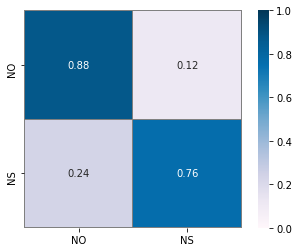

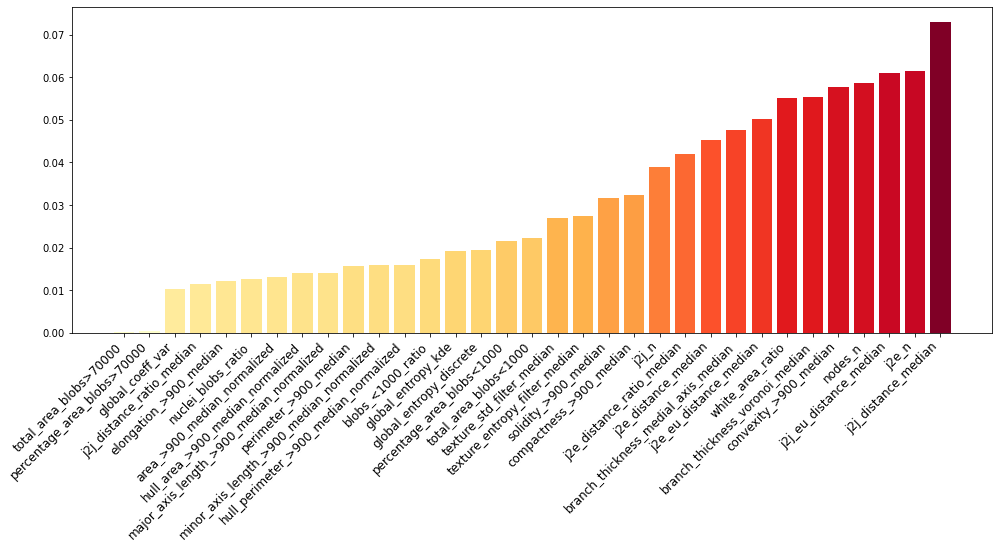

In [28]:
current_data = X_no_small
clf = RandomForestClassifier(oob_score=True, max_features="sqrt", n_estimators=2000, random_state=0)
clf.fit(current_data, y)

predicted_index = clf.oob_decision_function_.argmax(axis=1)
predicted = np.array(list(clf.classes_[i] for i in predicted_index))
print(classification_report(y, predicted))

cmx = confusion_matrix(y, predicted, labels=clf.classes_)
cmx_norm = cmx / cmx.sum(axis=1)[:, np.newaxis]
cmx_df = pd.DataFrame(cmx_norm, index=clf.classes_, columns=clf.classes_)
sns.heatmap(cmx_df, square=True, cmap='PuBu', annot=True, linewidths=0.1, linecolor='gray', vmin=0, vmax=1)

plot_ft_importance(clf.feature_importances_, current_data.columns)

In [29]:
generator = np.random.default_rng(seed=0)
n_iter = 10
rnd_states = generator.integers(0, 256, n_iter)
n_estimators = generator.integers(1500, 2500, n_iter)
fts_importance_list = []
for idx in range(n_iter):
    print(idx)
    clf = RandomForestClassifier(oob_score=True, max_features="sqrt", 
                                 n_estimators=n_estimators[idx], random_state=rnd_states[idx])
    clf.fit(X_borderless, y)
    predicted_index = clf.oob_decision_function_.argmax(axis=1)
    predicted = np.array(list(clf.classes_[i] for i in predicted_index))
    print(classification_report(y, predicted))
    fts_importance_list.append(clf.feature_importances_)

0
              precision    recall  f1-score   support

          NO       0.81      0.88      0.85        34
          NS       0.87      0.79      0.83        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68

1
              precision    recall  f1-score   support

          NO       0.81      0.85      0.83        34
          NS       0.84      0.79      0.82        34

    accuracy                           0.82        68
   macro avg       0.82      0.82      0.82        68
weighted avg       0.82      0.82      0.82        68

2
              precision    recall  f1-score   support

          NO       0.81      0.88      0.85        34
          NS       0.87      0.79      0.83        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68

3
           

In [30]:
fts_importance_list = np.array(fts_importance_list)
fts_importance_10 = fts_importance_list.mean(axis=0)
fts_importance_10

array([0.04518011, 0.02684909, 0.05484032, 0.03695658, 0.01402512,
       0.01496557, 0.01662517, 0.0148525 , 0.01523518, 0.01459312,
       0.0523198 , 0.05999569, 0.04504083, 0.04590345, 0.04171182,
       0.03911759, 0.06595923, 0.05821775, 0.01060677, 0.05975481,
       0.01176906, 0.01634303, 0.02022609, 0.00046651, 0.02023596,
       0.00047879, 0.04320975, 0.05532374, 0.02619195, 0.02548174,
       0.01861923, 0.01994454, 0.00895913])

(<Figure size 1188x432 with 1 Axes>, <AxesSubplot:>)

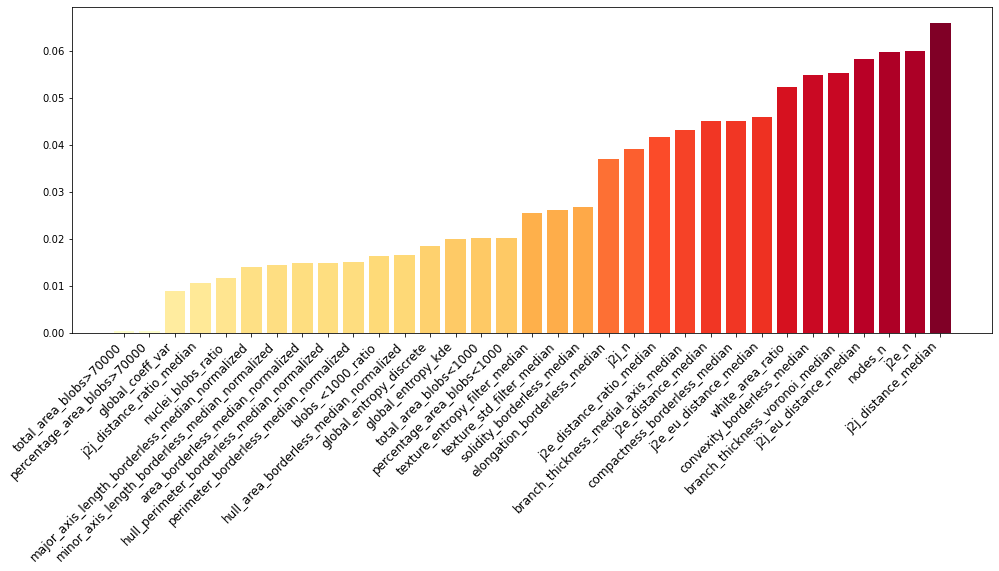

In [31]:
plot_ft_importance(fts_importance_10, X_borderless.columns)

In [32]:
ft_importance_dict = {k: v for k, v in zip(X_borderless.columns, fts_importance_10)}
ft_importance_dict

{'compactness_borderless_median': 0.0451801125210365,
 'solidity_borderless_median': 0.026849085205733047,
 'convexity_borderless_median': 0.05484032430280833,
 'elongation_borderless_median': 0.03695657500203604,
 'major_axis_length_borderless_median_normalized': 0.01402512288485458,
 'hull_perimeter_borderless_median_normalized': 0.01496557088576845,
 'hull_area_borderless_median_normalized': 0.016625166239237363,
 'area_borderless_median_normalized': 0.014852496667794918,
 'perimeter_borderless_median_normalized': 0.015235180737930776,
 'minor_axis_length_borderless_median_normalized': 0.014593123172748818,
 'white_area_ratio': 0.052319801099112086,
 'j2e_n': 0.05999568654057831,
 'j2e_distance_median': 0.04504082729640379,
 'j2e_eu_distance_median': 0.045903447166034186,
 'j2e_distance_ratio_median': 0.04171182358842845,
 'j2j_n': 0.03911758603391376,
 'j2j_distance_median': 0.0659592334000782,
 'j2j_eu_distance_median': 0.058217748987340404,
 'j2j_distance_ratio_median': 0.0106067

<AxesSubplot:>

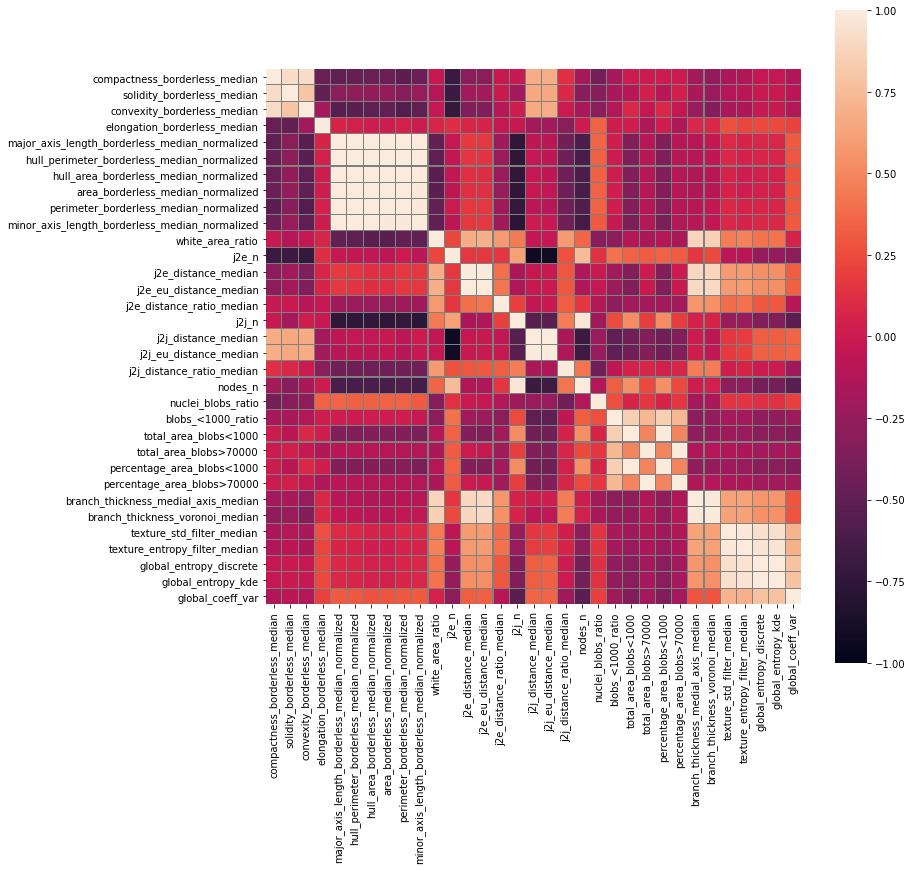

In [33]:
corr = X_borderless.corr()
plt.figure(figsize = (12,12))
sns.heatmap(corr, vmin=-1, vmax=1, square=True, linewidths=0.1, linecolor='gray')

<AxesSubplot:>

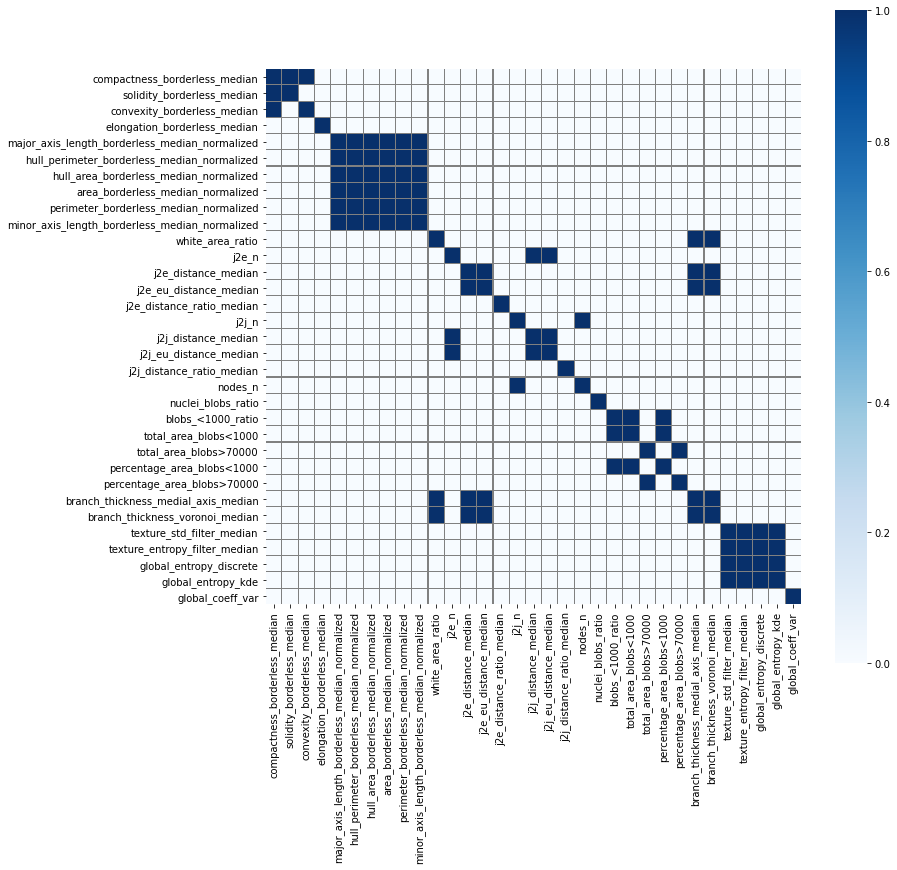

In [34]:
threshold = 0.8
thresh_corr = (abs(corr) > threshold).astype(int)
plt.figure(figsize = (12,12))
sns.heatmap(thresh_corr, vmin=0, vmax=1, square=True, cmap='Blues', linewidths=0.1, linecolor='gray')

In [35]:
def get_uncorrelated_columns(corr_df, theshold, ft_importance_dict): 
    keep = []
    remove = []
    thresh_corr_df = (abs(corr_df) > threshold).astype(int) 
    graph = nx.from_pandas_adjacency(thresh_corr_df)
    connected_components = nx.connected_components(graph)
    for component in connected_components:
        if len(component) == 1:
            keep.append(component.pop())
        else:
            current_ft_imp = {ft: ft_importance_dict[ft] for ft in component}
            max_ft = max(current_ft_imp, key=current_ft_imp.get)
            rest = [ft for ft in component if ft != max_ft]
            keep.append(max_ft)
            remove += rest
    return keep, remove


In [36]:
keep, remove = get_uncorrelated_columns(corr, threshold, ft_importance_dict)
keep, remove

(['convexity_borderless_median',
  'elongation_borderless_median',
  'hull_area_borderless_median_normalized',
  'branch_thickness_voronoi_median',
  'j2j_distance_median',
  'j2e_distance_ratio_median',
  'nodes_n',
  'j2j_distance_ratio_median',
  'nuclei_blobs_ratio',
  'percentage_area_blobs<1000',
  'percentage_area_blobs>70000',
  'texture_std_filter_median',
  'global_coeff_var'],
 ['solidity_borderless_median',
  'compactness_borderless_median',
  'major_axis_length_borderless_median_normalized',
  'area_borderless_median_normalized',
  'perimeter_borderless_median_normalized',
  'minor_axis_length_borderless_median_normalized',
  'hull_perimeter_borderless_median_normalized',
  'j2e_eu_distance_median',
  'branch_thickness_medial_axis_median',
  'white_area_ratio',
  'j2e_distance_median',
  'j2j_eu_distance_median',
  'j2e_n',
  'j2j_n',
  'total_area_blobs<1000',
  'blobs_<1000_ratio',
  'total_area_blobs>70000',
  'global_entropy_kde',
  'global_entropy_discrete',
  'textur

In [39]:
keep = [col for col in keep if col not in ['percentage_area_blobs<1000', 'percentage_area_blobs>70000']]
keep

['convexity_borderless_median',
 'elongation_borderless_median',
 'hull_area_borderless_median_normalized',
 'branch_thickness_voronoi_median',
 'j2j_distance_median',
 'j2e_distance_ratio_median',
 'nodes_n',
 'j2j_distance_ratio_median',
 'nuclei_blobs_ratio',
 'texture_std_filter_median',
 'global_coeff_var']

In [41]:
X_borderless_filtered = X_borderless[keep]
X_borderless_filtered

convexity_borderless_median  elongation_borderless_median  \
NegsiRNA_E3_NO                     0.927603                      1.448576   
NegsiRNA_L2_NS                     0.925205                      1.523195   
NegsiRNA_H3_NO                     0.937294                      1.472948   
NegsiRNA_G3_NS                     0.944047                      1.521927   
NegsiRNA_B1_NO                     0.951059                      1.501067   
...                                     ...                           ...   
NegsiRNA_I2_NO                     0.934052                      1.565276   
NegsiRNA_G3_NO                     0.910640                      1.589326   
NegsiRNA_A1_NO                     0.924468                      1.544299   
NegsiRNA_I3_NO                     0.929273                      1.571240   
NegsiRNA_H3_NS                     0.950238                      1.493704   

                hull_area_borderless_median_normalized  \
NegsiRNA_E3_NO                               77.699275   
NegsiRNA_L2_NS                              261.922078   
NegsiRNA_H3_NO                               90.040000   
NegsiRNA_G3_NS                              146.123810   
NegsiRNA_B1_NO                               66.222222   
...                                                ...   
NegsiRNA_I2_NO                               81.909774   
NegsiRNA_G3_NO                              111.119266   
NegsiRNA_A1_NO                              202.746835   
NegsiRNA_I3_NO                              108.871560   
NegsiRNA_H3_NS                               87.349593   

                branch_thickness_voronoi_median  j2j_distance_median  \
NegsiRNA_E3_NO                         8.944272            40.266715   
NegsiRNA_L2_NS                         6.000000            38.601632   
NegsiRNA_H3_NO                        10.295630            43.120287   
NegsiRNA_G3_NS                         7.615773            55.349168   
NegsiRNA_B1_NO                        10.000000            46.250846   
...                                         ...                  ...   
NegsiRNA_I2_NO                         8.544003            44.198083   
NegsiRNA_G3_NO                         9.899495            38.842477   
NegsiRNA_A1_NO                        11.000000            49.259924   
NegsiRNA_I3_NO                         8.944272            42.329852   
NegsiRNA_H3_NS                         8.944272            55.155517   

                j2e_distance_ratio_median  nodes_n  j2j_distance_ratio_median  \
NegsiRNA_E3_NO                   0.941882     2187                   0.931580   
NegsiRNA_L2_NS                   0.940715     1639                   0.930580   
NegsiRNA_H3_NO                   0.946282     1850                   0.933376   
NegsiRNA_G3_NS                   0.943207     1432                   0.929196   
NegsiRNA_B1_NO                   0.948505     1891                   0.931275   
...                                   ...      ...                        ...   
NegsiRNA_I2_NO                   0.944422     1894                   0.930120   
NegsiRNA_G3_NO                   0.941856     1943                   0.932586   
NegsiRNA_A1_NO                   0.946974     1275                   0.928598   
NegsiRNA_I3_NO                   0.941784     1813                   0.929490   
NegsiRNA_H3_NS                   0.943127     1564                   0.931112   

                nuclei_blobs_ratio  texture_std_filter_median  \
NegsiRNA_E3_NO            1.102564                1037.078857   
NegsiRNA_L2_NS            1.188889                 937.887817   
NegsiRNA_H3_NO            1.049383                1728.560547   
NegsiRNA_G3_NS            1.133858                1131.844849   
NegsiRNA_B1_NO            1.138365                1264.981201   
...                            ...                        ...   
NegsiRNA_I2_NO            1.114094                1820.860474   
NegsiRNA_G3_NO            1.088889  

In [42]:
generator = np.random.default_rng(seed=0)
n_iter = 10
rnd_states = generator.integers(0, 256, n_iter)
n_estimators = generator.integers(1500, 2500, n_iter)
fts_importance_list = []
for idx in range(n_iter):
    print(idx)
    clf = RandomForestClassifier(oob_score=True, max_features="sqrt", 
                                 n_estimators=n_estimators[idx], random_state=rnd_states[idx])
    clf.fit(X_borderless_filtered, y)
    predicted_index = clf.oob_decision_function_.argmax(axis=1)
    predicted = np.array(list(clf.classes_[i] for i in predicted_index))
    print(classification_report(y, predicted))
    fts_importance_list.append(clf.feature_importances_)

0
              precision    recall  f1-score   support

          NO       0.83      0.85      0.84        34
          NS       0.85      0.82      0.84        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68

1
              precision    recall  f1-score   support

          NO       0.85      0.85      0.85        34
          NS       0.85      0.85      0.85        34

    accuracy                           0.85        68
   macro avg       0.85      0.85      0.85        68
weighted avg       0.85      0.85      0.85        68

2
              precision    recall  f1-score   support

          NO       0.83      0.85      0.84        34
          NS       0.85      0.82      0.84        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68

3
           

(<Figure size 396x432 with 1 Axes>, <AxesSubplot:>)

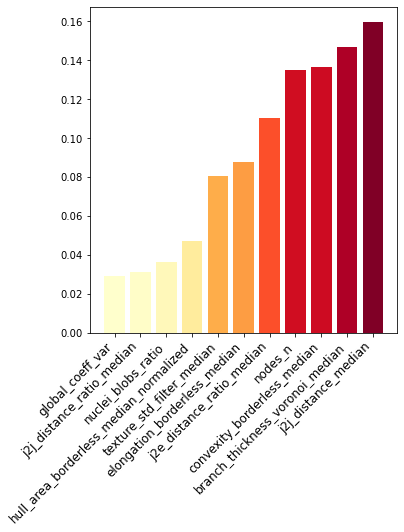

In [44]:
fts_importance_list = np.array(fts_importance_list)
fts_importance_10 = fts_importance_list.mean(axis=0)
plot_ft_importance(fts_importance_10, X_borderless_filtered.columns)

Text(0, 0.5, 'branch_thickness_voronoi_median')

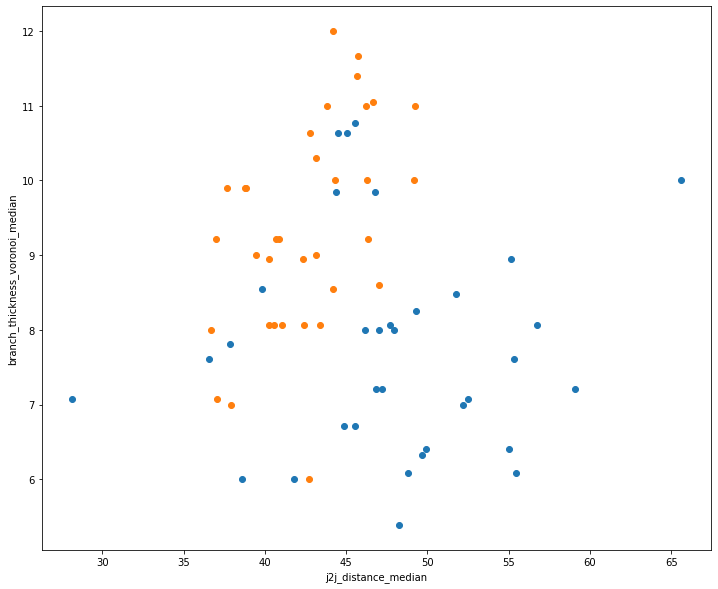

In [45]:
ns_data = X_borderless_filtered[df_negsi['stimulus'] == 'NS']
no_data = X_borderless_filtered[df_negsi['stimulus'] == 'NO']
x_ft = 'j2j_distance_median'
y_ft = 'branch_thickness_voronoi_median'
plt.figure(figsize=(12, 10))
plt.scatter(ns_data[x_ft], ns_data[y_ft])
plt.scatter(no_data[x_ft], no_data[y_ft])
plt.xlabel(x_ft)
plt.ylabel(y_ft)

In [46]:
def get_pca_df(df):
    n_components = len(df.columns) - 1
    columns = [f'pc_{iii}' for iii in range(1, n_components+1)]
    pipe = Pipeline([('scaler', MinMaxScaler()), ('pca', PCA(n_components=n_components))]) # normalization and PCA
    df_pca_values = pipe.fit_transform(df)
    df_pca = pd.DataFrame(data=df_pca_values, index=df.index, columns=columns)
    return df_pca, pipe

In [49]:
df_pca, pipe_pca = get_pca_df(X_borderless_filtered)
df_pca

pc_1      pc_2      pc_3      pc_4      pc_5      pc_6  \
NegsiRNA_E3_NO  0.098604 -0.292503 -0.232131 -0.191419  0.203989 -0.157361   
NegsiRNA_L2_NS  0.474396  0.333104 -0.474591 -0.270951 -0.060632  0.011687   
NegsiRNA_H3_NO -0.564162 -0.275236  0.248233 -0.197741  0.203243 -0.152975   
NegsiRNA_G3_NS  0.236371  0.354035  0.231424 -0.062123 -0.135844  0.028195   
NegsiRNA_B1_NO -0.187049 -0.329624  0.122444  0.079859 -0.315002 -0.089173   
...                  ...       ...       ...       ...       ...       ...   
NegsiRNA_I2_NO -0.294676  0.209166  0.097123  0.230565  0.069996 -0.162494   
NegsiRNA_G3_NO -0.262374 -0.102449 -0.391418 -0.010517  0.336770  0.191145   
NegsiRNA_A1_NO -0.618123  0.615335  0.157361 -0.087614 -0.336760  0.001270   
NegsiRNA_I3_NO  0.010916  0.230953 -0.143841  0.128496  0.102686  0.065718   
NegsiRNA_H3_NS -0.010911 -0.012499  0.441084 -0.112527  0.124024  0.044067   

                    pc_7      pc_8      pc_9     pc_10  
NegsiRNA_E3_NO -0.085388 -0.148596  0.044663 -0.012884  
NegsiRNA_L2_NS  0.292370  0.100775 -0.159553  0.036162  
NegsiRNA_H3_NO -0.045214  0.202038 -0.032015  0.088291  
NegsiRNA_G3_NS  0.024314 -0.059180  0.138973 -0.055955  
NegsiRNA_B1_NO  0.115918 -0.129554  0.038860  0.075877  
...                  ...       ...       ...       ...  
NegsiRNA_I2_NO -0.187161  0.105996 -0.098871 -0.056912  
NegsiRNA_G3_NO  0.114951  0.030439 -0.013423 -0.126500  
NegsiRNA_A1_NO -0.048442 -0.160413 -0.138747 -0.052773  
NegsiRNA_I3_NO -0.095417 -0.143602  0.007024 -0.024338  
NegsiRNA_H3_NS -0.046168 -0.006034  0.072958 -0.052796  

[68 rows x 10 columns]

Text(0, 0.5, 'pc_2')

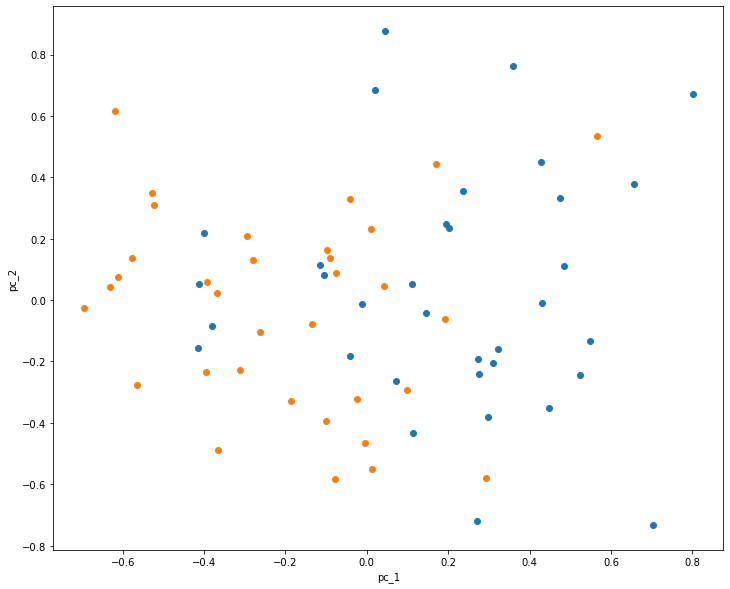

In [50]:
ns_data = df_pca[df_negsi['stimulus'] == 'NS']
no_data = df_pca[df_negsi['stimulus'] == 'NO']
x_ft = 'pc_1'
y_ft = 'pc_2'
plt.figure(figsize=(12, 10))
plt.scatter(ns_data[x_ft], ns_data[y_ft])
plt.scatter(no_data[x_ft], no_data[y_ft])
plt.xlabel(x_ft)
plt.ylabel(y_ft)

In [51]:
df_pca_2ft = df_pca[['pc_1', 'pc_2']]
clf = Pipeline([('model', SVC(kernel='linear', C=100))])
#param_grid = [
 # {'model__C': np.arange(0.1, 1000, 10)},
#]

#clf = GridSearchCV(pipe, param_grid, n_jobs=-1)
#print("Best parameter (CV score=%0.3f):" % clf.best_score_)
#print(clf.best_params_)
scores = cross_val_score(clf, df_pca_2ft, y, cv=10)
scores.mean(), scores.std()

(0.7333333333333333, 0.11751393027860062)

In [52]:
clf.fit(df_pca_2ft, y)
y_pred = clf.predict(df_pca_2ft)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          NO       0.76      0.76      0.76        34
          NS       0.76      0.76      0.76        34

    accuracy                           0.76        68
   macro avg       0.76      0.76      0.76        68
weighted avg       0.76      0.76      0.76        68



In [53]:
def plot_boundaries(X, y, clf, x_coord, y_coord, n_points=100):
    colors = {'NS': 'tab:red', 'NO': 'tab:blue'}
    colors_others = {'NS': 'magenta', 'NO': 'tab:cyan'}
    model = clf['model']
    padding = 0.01
    

    min_x = X[x_coord].min() - padding
    max_x = X[x_coord].max() + padding
    min_y = X[y_coord].min() - padding
    max_y = X[y_coord].max() + padding
    
    #min_x = min_y = 0
    #max_x = max_y = 5
    xx, yy = np.meshgrid(np.linspace(min_x, max_x, n_points), np.linspace(min_y, max_y, n_points))

    predictions = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    fig, axes = plt.subplots(1, figsize=(10, 10))

    axes.contourf(xx, yy, np.sign(predictions), cmap=plt.cm.coolwarm, alpha=0.5)
    # axes.contour(xx, yy, predictions, colors='k', levels=[-1, 0, 1], alpha=0.8, linestyles=['--', '-', '--'])

    for label in ['NO', 'NS']:
        current_X = X[y == label]
        axes.scatter(current_X[x_coord], current_X[y_coord], label=label, color=colors[label])

    name_and_plate = set("_".join(name.split("_")[:-1]) for name in X.index)

    for nap in name_and_plate:
        x0, y0 = X.loc[f'{nap}_NS', x_coord], X.loc[f'{nap}_NS', y_coord]
        x1, y1 = X.loc[f'{nap}_NO', x_coord], X.loc[f'{nap}_NO', y_coord]
        axes.plot((x0, x1), (y0, y1), c='gray')
        axes.plot((x0, x1), (y0, y1), c='gray')
        #axes.text(x0 + padding / 10, y0 + padding / 10, nap)

    axes.set_xlabel(x_coord)
    axes.set_ylabel(y_coord)
    axes.legend()

    return fig, axes

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:xlabel='pc_1', ylabel='pc_2'>)

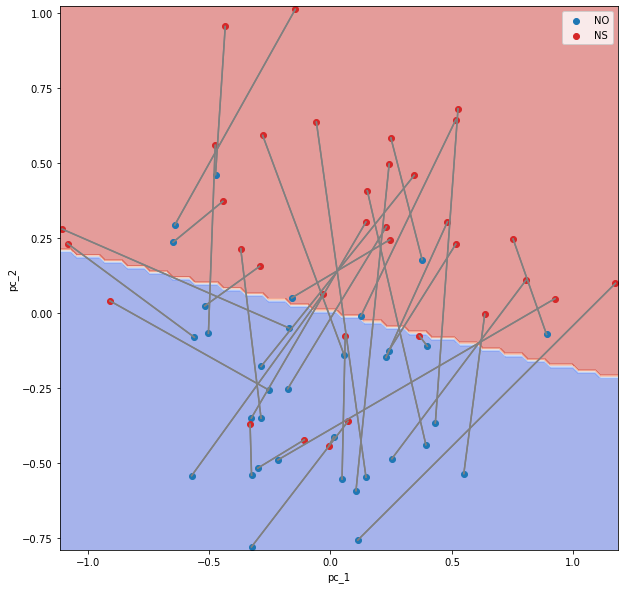

In [192]:
plot_boundaries(df_pca_2ft, y, clf, 'pc_1', 'pc_2')

In [205]:
df_blobs_paths = glob.glob(os.path.join('../data/interim/dataframes/blobs_data', 'NegsiRNA*.csv'))
dfs = {path.split("/")[-1].split(".")[0]: pd.read_csv(path, index_col=0) for path in df_blobs_paths}

In [236]:
upper_thresh = 40000
lower_thresh = 900
n_blobs_dict = {}
for name, df in dfs.items():
    df_filtered = df[~(df['is_at_border']) & (df['area'] > lower_thresh) & (df['area'] < upper_thresh)]
    n_blobs_dict[name] = len(df_filtered)

In [237]:
df_n_blobs = pd.DataFrame.from_dict(n_blobs_dict, orient='index', columns=['n_blobs'])
df_n_blobs = df_n_blobs[df_n_blobs.index.str.split("_").str[2] != 'CA'].sort_values(by='n_blobs')
df_n_blobs

n_blobs
NegsiRNA_E1_NS        48
NegsiRNA_C3c_NS       57
NegsiRNA_L3_NS        63
NegsiRNA_L2_NS        64
NegsiRNA_A1_NO        77
NegsiRNA_L2_NO        78
NegsiRNA_A1_NS        78
NegsiRNA_A1b_NO       81
NegsiRNA_L3_NO        84
NegsiRNA_F2_NS        86
NegsiRNA_A2b_NO       87
NegsiRNA_F3_NS        88
NegsiRNA_E1_NO        88
NegsiRNA_D3_NS        88
NegsiRNA_C3c_NO       91
NegsiRNA_D3_NO        93
NegsiRNA_F2_NO        93
NegsiRNA_A1b_NS       95
NegsiRNA_E2_NS        96
NegsiRNA_A3_NO        96
NegsiRNA_B2_NS        97
NegsiRNA_B2_NO        98
NegsiRNA_F3_NO        99
NegsiRNA_G2_NS       101
NegsiRNA_E2_NO       102
NegsiRNA_G3_NS       104
NegsiRNA_I3_NS       105
NegsiRNA_G3_NO       106
NegsiRNA_I3_NO       106
NegsiRNA_A2_NO       110
NegsiRNA_I1_NO       112
NegsiRNA_C2_NO       115
NegsiRNA_A2_NS       116
NegsiRNA_C3b_NS      118
NegsiRNA_E3_NS       119
NegsiRNA_H3_NS       121
NegsiRNA_C3_NS       121
NegsiRNA_A2b_NS      121
NegsiRNA_I2_NS       123
NegsiRNA_G2_NO       123
NegsiRNA_H3_NO       125
NegsiRNA_C2_NS       127
NegsiRNA_I2_NO       128
NegsiRNA_H2_NS       129
NegsiRNA_A3_NS       131
NegsiRNA_H1_NO       133
NegsiRNA_E3_NO       134
NegsiRNA_D2_NO       135
NegsiRNA_D2_NS       137
NegsiRNA_H2_NO       138
NegsiRNA_B1_NO       143
NegsiRNA_D1_NO       144
NegsiRNA_C1_NO       144
NegsiRNA_B1_NS       145
NegsiRNA_C1_NS       145
NegsiRNA_C3_NO       145
NegsiRNA_D1_NS       148
NegsiRNA_H1_NS       149
NegsiRNA_B3_NO       151
NegsiRNA_C3b_NO      151
NegsiRNA_I1_NS       156
NegsiRNA_B3_NS       157
NegsiRNA_F1_NS       157
NegsiRNA_G1_NO       158
NegsiRNA_F1_NO       168
NegsiRNA_G1_NS       182
NegsiRNA_L1_NO       184
NegsiRNA_L1_NS       221

In [233]:
X_borderless_filtered.loc[df_n_blobs.index]

NegsiRNA_E3_NS                          6.324555                 4.902409   
NegsiRNA_E3_NO                          8.944272                 5.042615   
NegsiRNA_H1_NS                          8.000000                 5.237782   
NegsiRNA_H1_NO                         11.000000                 5.245799   
NegsiRNA_B1_NO                         10.000000                 5.269819   
NegsiRNA_L2_NO                          8.000000                 5.293038   
NegsiRNA_D1_NS                          6.708204                 5.108597   

                 j2e_distance_ratio_median  j2e_distance_ratio_entropy  \
NegsiRNA_H2_NS                    0.946163                   -2.538945   
NegsiRNA_A1b_NS                   0.938478                   -2.647304   
NegsiRNA_G3_NO                    0.941856                   -2.805585   
NegsiRNA_H2_NO                    0.943089                   -2.594054   
NegsiRNA_L2_NS                    0.940715                   -2.671102   
NegsiRNA_F2_NS                    0.945821                   -2.838887   
NegsiRNA_G2_NS                    0.947488                   -2.736165   
NegsiRNA_L1_NO                    0.942788                   -2.884541   
NegsiRNA_G1_NS                    0.946216                   -2.838967   
NegsiRNA_E1_NO                    0.947916                   -2.502963   
NegsiRNA_F2_NO                    0.947659                   -2.655631   
NegsiRNA_L3_NS                    0.939683                   -2.743578   
NegsiRNA_G3_NS                    0.943207                   -2.893772   
NegsiRNA_I3_NO                    0.941784                   -2.912259   
NegsiRNA_I2_NO                    0.944422                   -2.900120   
NegsiRNA_A2_NO                    0.946163                   -2.842234   
NegsiRNA_C1_NO                    0.946543                   -2.795875   
NegsiRNA_D1_NO                    0.947673                   -2.784449   
NegsiRNA_C3_NO                    0.946282                   -2.821488   
NegsiRNA_D2_NS                    0.944212                   -2.780516   
NegsiRNA_L1_NS                    0.944103                   -2.717291   
NegsiRNA_A3_NS                    0.941784                   -2.572352   
NegsiRNA_B3_NS                    0.936741                   -2.593717   
NegsiRNA_A1b_NO                   0.945209                   -2.502069   
NegsiRNA_C1_NS                    0.944382                   -2.616955   
NegsiRNA_A2b_NO                   0.944157                   -2.959881   
NegsiRNA_C3c_NS                   0.939713                   -2.484994   
NegsiRNA_A2_NS                    0.941784                   -2.884074   
NegsiRNA_H3_NO                    0.946282                   -2.834516   
NegsiRNA_A1_NS                    0.939556                   -2.850290   
NegsiRNA_D2_NO                    0.944802                   -2.872650   
NegsiRNA_E1_NS                    0.939820                   -2.585990   
NegsiRNA_B1_NS                    0.939954                   -2.657966   
NegsiRNA_B2_NS                    0.946523                   -2.793590   
NegsiRNA_L3_NO                    0.945209                   -2.735216   
NegsiRNA_B2_NO                    0.943844                   -2.981728   
NegsiRNA_C2_NO                    0.945857                   -2.858490   
NegsiRNA_E2_NS                    0.943345                   -2.680443   
NegsiRNA_I1_NO                    0.947115                   -2.919933   
NegsiRNA_I1_NS                    0.944103                   -2.956568   
NegsiRNA_G1_NO                    0.946567                   -2.754938   
NegsiRNA_C3_NS                    0.942572                   -2.797975   
NegsiRNA_A1_NO                    0.946974                   -2.955289   
NegsiRNA_F1_NO                    0.946842                   -2.846113   
NegsiRNA_C3b_NS                   0.946216                   -3.090235   
NegsiRNA_F1_NS                    0.942248              

In [242]:
nuclei_img, ccj_img, seg_img, _ = utils.load_images('../data/raw/images', 'NegsiRNA_E1_NS')
df_blobs, label_img = blobsutils.get_blobs_measurements(seg_img, return_img=True)

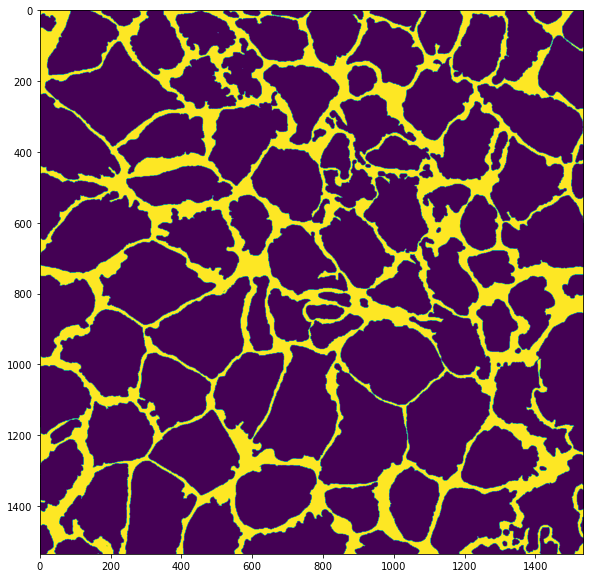

In [262]:
plt.figure(figsize=(10, 10))
plt.imshow(seg_img)

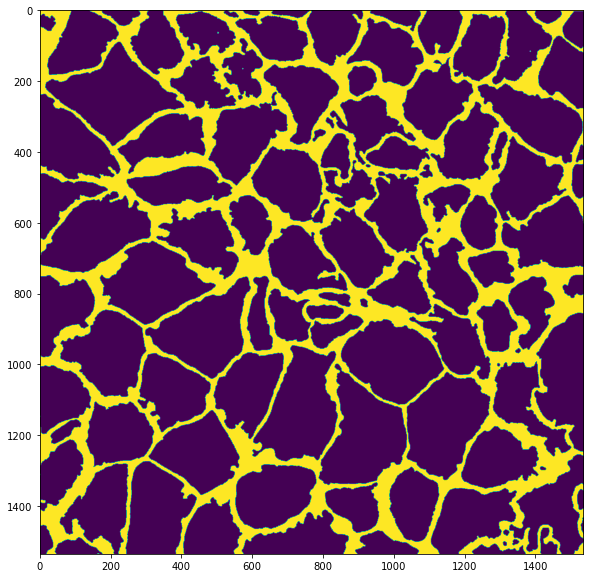

In [265]:
seg_img_dilated = dilation(seg_img, square(3))
plt.figure(figsize=(10, 10))
plt.imshow(seg_img_dilated)

In [266]:
df_blobs_dilated, label_img_dilated = blobsutils.get_blobs_measurements(seg_img_dilated, return_img=True)

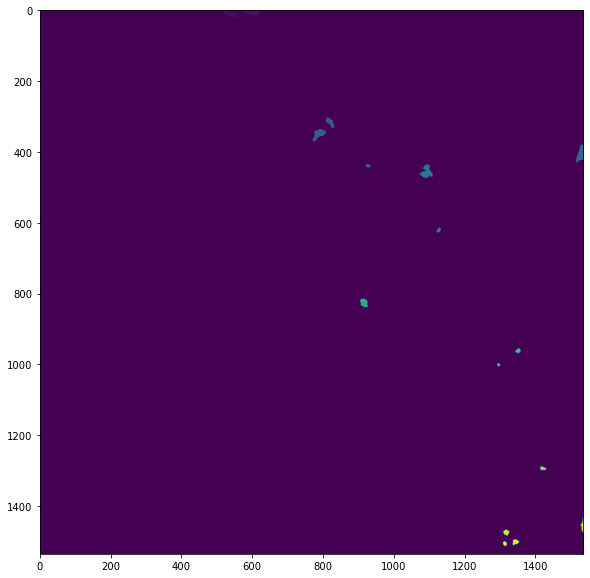

In [274]:
upper_thresh = 70000
lower_thresh = 1000
discarded_blobs = (df_blobs_dilated['area'] > upper_thresh) | (df_blobs_dilated['area'] < lower_thresh)
plt.figure(figsize=(10, 10))
masked_img = label_img_dilated
masked_img[~np.isin(label_img_dilated, df_blobs_dilated.loc[discarded_blobs, 'label'].values)] = 0
plt.imshow(masked_img)

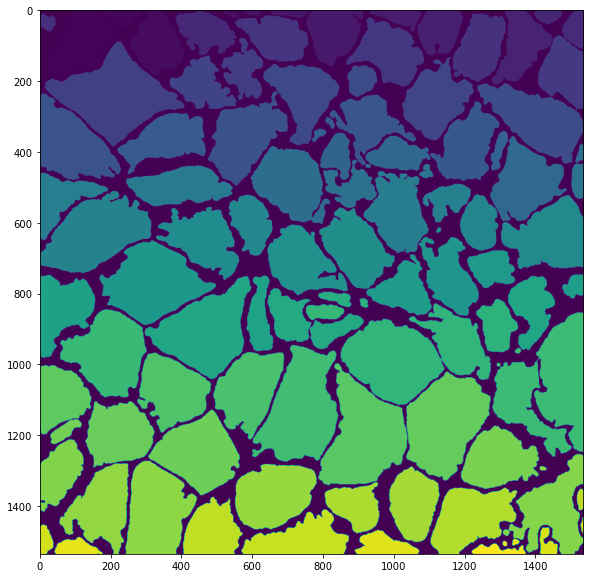

In [243]:
plt.figure(figsize=(10, 10))
plt.imshow(label_img)

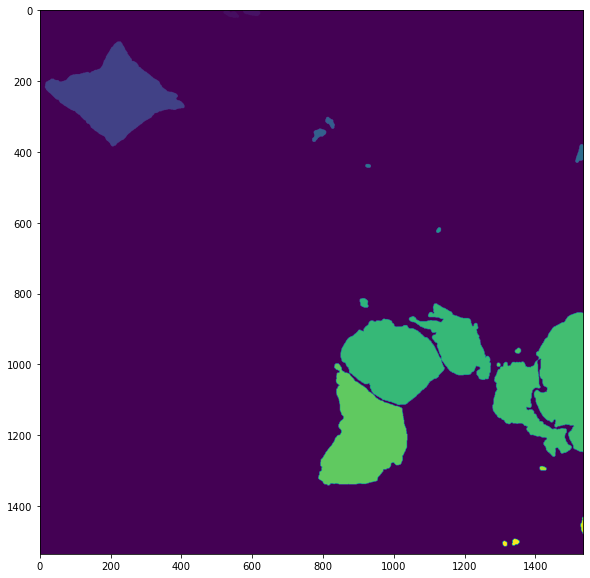

In [261]:
upper_thresh = 50000
lower_thresh = 900
discarded_blobs = (df_blobs['area'] > upper_thresh) | (df_blobs['area'] < lower_thresh)
plt.figure(figsize=(10, 10))
masked_img = label_img
masked_img[~np.isin(label_img, df_blobs.loc[discarded_blobs, 'label'].values)] = 0
plt.imshow(masked_img)

In [16]:
mi = mutual_info_classif(X, y, n_neighbors=10)
f_score, _ = f_classif(X, y)
df_tests = pd.DataFrame(np.stack((mi, f_score)).T, index=X.columns, columns=['mutual_info', 'f_score'])
df_tests

mutual_info    f_score
white_area_ratio                   0.136805  19.770762
area_median                        0.000000   0.518955
area_entropy                       0.000000   0.092104
perimeter_median                   0.000000   0.004303
perimeter_entropy                  0.000000   0.001149
...                                     ...        ...
texture_entropy_filter_median      0.084976   9.680452
texture_entropy_filter_entropy     0.168532  19.565756
global_entropy_discrete            0.050391   4.414829
global_entropy_kde                 0.054280   4.386013
global_coeff_var                   0.000000   0.254087

[90 rows x 2 columns]

In [17]:
df_tests['mutual_info_norm'] = df_tests['mutual_info'] / df_tests['mutual_info'].max()
df_tests['f_score_norm'] = df_tests['f_score'] / df_tests['f_score'].max() 
df_tests

mutual_info    f_score  mutual_info_norm  \
white_area_ratio                   0.136805  19.770762          0.669035   
area_median                        0.000000   0.518955          0.000000   
area_entropy                       0.000000   0.092104          0.000000   
perimeter_median                   0.000000   0.004303          0.000000   
perimeter_entropy                  0.000000   0.001149          0.000000   
...                                     ...        ...               ...   
texture_entropy_filter_median      0.084976   9.680452          0.415567   
texture_entropy_filter_entropy     0.168532  19.565756          0.824195   
global_entropy_discrete            0.050391   4.414829          0.246436   
global_entropy_kde                 0.054280   4.386013          0.265451   
global_coeff_var                   0.000000   0.254087          0.000000   

                                f_score_norm  
white_area_ratio                    0.863312  
area_median                         0.022661  
area_entropy                        0.004022  
perimeter_median                    0.000188  
perimeter_entropy                   0.000050  
...                                      ...  
texture_entropy_filter_median       0.422707  
texture_entropy_filter_entropy      0.854360  
global_entropy_discrete             0.192778  
global_entropy_kde                  0.191520  
global_coeff_var                    0.011095  

[90 rows x 4 columns]

In [18]:
df_tests.sort_values(by='mutual_info_norm', ascending=False).head(50)

mutual_info    f_score  \
j2j_distance_median                      0.204481  15.453869   
convexity_median                         0.199596  12.718033   
j2e_n                                    0.199149  22.901075   
convexity_>900_median                    0.192459   6.060079   
j2j_eu_distance_median                   0.176395  14.543593   
texture_entropy_filter_entropy           0.168532  19.565756   
nodes_n                                  0.167684   6.955003   
convexity_borderless_median              0.166846  13.406660   
branch_thickness_voronoi_median          0.158716  20.760325   
solidity_>900_median                     0.154925   4.825539   
compactness_>900_median                  0.149565   4.885071   
j2e_distance_median                      0.141085  18.998280   
compactness_borderless_median            0.140667  15.151217   
j2j_eu_distance_entropy                  0.138890  11.222344   
white_area_ratio                         0.136805  19.770762   
j2e_eu_distance_median                   0.129759  19.590543   
solidity_median                          0.119690   9.418247   
branch_thickness_medial_axis_median      0.119297  19.488989   
j2j_distance_entropy                     0.116732  11.454670   
solidity_borderless_median               0.110439  10.198140   
branch_thickness_medial_axis_entropy     0.109849  13.654966   
convexity_borderless_entropy             0.108618   5.068498   
j2e_distance_ratio_entropy               0.100025   6.670095   
compactness_median                       0.098053   8.008325   
branch_thickness_voronoi_entropy         0.095930  10.676324   
elongation_borderless_median             0.093911   5.411369   
texture_std_filter_median                0.090488  10.926786   
texture_std_filter_entropy               0.087698   4.920899   
texture_entropy_filter_median            0.084976   9.680452   
j2e_distance_ratio_median                0.082798  13.346066   
j2j_n                                    0.071925   5.272152   
convexity_entropy                        0.060595   4.081711   
convexity_>900_entropy                   0.058110   3.229978   
global_entropy_kde                       0.054280   4.386013   
global_entropy_discrete                  0.050391   4.414829   
elongation_borderless_entropy            0.048928   5.940507   
hull_perimeter_borderless_entropy        0.046917   0.747737   
solidity_borderless_entropy              0.045373   4.052240   
j2e_distance_entropy                     0.032563   1.246032   
elongation_median                        0.028197   2.305345   
minor_axis_length_borderless_entropy     0.026821   1.683712   
minor_axis_length_>900_entropy           0.022328   2.464900   
perimeter_borderless_entropy             0.018710   0.043546   
minor_axis_length_entropy                0.018298   2.555764   
hull_area_borderless_entropy             0.016053   0.026329   
area_borderless_entropy                  0.013965   0.007763   
j2j_distance_ratio_median                0.009607   1.263058   
compactness_entropy                      0.009297   0.318867   
hull_area_>900_median                    0.006837   1.293750   
elongation_entropy                       0.006723   0.040646   

                                      mutual_info_norm  f_score_norm  
j2j_distance_median                           1.000000      0.674810  
convexity_median                              0.976112      0.555347  
j2e_n                                         0.973923      1.000000  
convexity_>900_median                         0.941206      0.264620  
j2j_eu_distance_median                        0.862648      0.635062  
texture_entropy_filter_entropy                0.824195      0.854360  
nodes_n                                       0.820046      0.303698  
convexity_borderless_median                   0.815950      0.585416  
branch_thickness_voronoi_median               0.776191      0.906522  
solidity_>900_median                          0.757648      0.2

In [19]:
mi_threshold = 0.2
df_tests_thresh = df_tests[df_tests['mutual_info_norm'] > mi_threshold]
df_tests_thresh

mutual_info    f_score  \
white_area_ratio                         0.136805  19.770762   
compactness_median                       0.098053   8.008325   
solidity_median                          0.119690   9.418247   
convexity_median                         0.199596  12.718033   
convexity_entropy                        0.060595   4.081711   
hull_perimeter_borderless_entropy        0.046917   0.747737   
compactness_borderless_median            0.140667  15.151217   
solidity_borderless_median               0.110439  10.198140   
solidity_borderless_entropy              0.045373   4.052240   
convexity_borderless_median              0.166846  13.406660   
convexity_borderless_entropy             0.108618   5.068498   
elongation_borderless_median             0.093911   5.411369   
elongation_borderless_entropy            0.048928   5.940507   
compactness_>900_median                  0.149565   4.885071   
solidity_>900_median                     0.154925   4.825539   
convexity_>900_median                    0.192459   6.060079   
convexity_>900_entropy                   0.058110   3.229978   
j2e_n                                    0.199149  22.901075   
j2e_distance_median                      0.141085  18.998280   
j2e_eu_distance_median                   0.129759  19.590543   
j2e_distance_ratio_median                0.082798  13.346066   
j2e_distance_ratio_entropy               0.100025   6.670095   
j2j_n                                    0.071925   5.272152   
j2j_distance_median                      0.204481  15.453869   
j2j_distance_entropy                     0.116732  11.454670   
j2j_eu_distance_median                   0.176395  14.543593   
j2j_eu_distance_entropy                  0.138890  11.222344   
nodes_n                                  0.167684   6.955003   
branch_thickness_medial_axis_median      0.119297  19.488989   
branch_thickness_medial_axis_entropy     0.109849  13.654966   
branch_thickness_voronoi_median          0.158716  20.760325   
branch_thickness_voronoi_entropy         0.095930  10.676324   
texture_std_filter_median                0.090488  10.926786   
texture_std_filter_entropy               0.087698   4.920899   
texture_entropy_filter_median            0.084976   9.680452   
texture_entropy_filter_entropy           0.168532  19.565756   
global_entropy_discrete                  0.050391   4.414829   
global_entropy_kde                       0.054280   4.386013   

                                      mutual_info_norm  f_score_norm  
white_area_ratio                              0.669035      0.863312  
compactness_median                            0.479523      0.349692  
solidity_median                               0.585336      0.411258  
convexity_median                              0.976112      0.555347  
convexity_entropy                             0.296334      0.178232  
hull_perimeter_borderless_entropy             0.229447      0.032651  
compactness_borderless_median                 0.687922      0.661594  
solidity_borderless_median                    0.540096      0.445313  
solidity_borderless_entropy                   0.221892      0.176945  
convexity_borderless_median                   0.815950      0.585416  
convexity_borderless_entropy                  0.531188      0.221321  
elongation_borderless_median                  0.459266      0.236293  
elongation_borderless_entropy                 0.239277      0.259399  
compactness_>900_median                       0.731439      0.213312  
solidity_>900_median                          0.757648      0.210712  
convexity_>900_median                         0.941206      0.264620  
convexity_>900_entropy                        0.284182      0.141040  
j2e_n                                         0.973923      1.000000  
j2e_distance_median                           0.689968      0.829580  
j2e_eu_distance_median                        0.634575      0.855442  
j2e_distance_ratio_median                     0.40

In [16]:
df_tests_thresh.sort_values('mutual_info_norm', ascending=False).head(40)

mutual_info    f_score  mutual_info_norm  \
j2j_distance_median                     0.204481  15.453869          1.000000   
convexity_>900_mad                      0.203955   4.651773          0.997429   
j2e_n                                   0.201459  22.901075          0.985220   
convexity_borderless_mean               0.200407  12.377157          0.980074   
convexity_median                        0.199596  12.718033          0.976112   
convexity_mad                           0.193028   4.874728          0.943988   
convexity_>900_median                   0.192459   6.060079          0.941206   
convexity_mean                          0.186233   9.937182          0.910757   
branch_thickness_voronoi_mean           0.180971  20.736773          0.885025   
j2j_eu_distance_mean                    0.179887  13.939248          0.879722   
j2j_eu_distance_median                  0.176395  14.543593          0.862648   
compactness_>900_mean                   0.174654   3.619658          0.854132   
j2j_distance_mean                       0.170676  14.215748          0.834680   
texture_entropy_filter_entropy          0.168532  19.565756          0.824195   
nodes_n                                 0.167655   6.955003          0.819904   
convexity_>900_mean                     0.167237   4.455454          0.817859   
convexity_borderless_median             0.166846  13.406660          0.815950   
convexity_borderless_mad                0.163033   3.102893          0.797301   
j2e_distance_mode                       0.162290  11.515910          0.793670   
compactness_borderless_mean             0.159122  20.502705          0.778176   
texture_entropy_filter_mad              0.157388  13.682080          0.769694   
branch_thickness_medial_axis_mean       0.157192  16.687876          0.768738   
solidity_>900_median                    0.154925   4.825539          0.757648   
branch_thickness_voronoi_median         0.154365  20.760325          0.754911   
compactness_borderless_mode             0.150611  14.315375          0.736553   
compactness_>900_median                 0.149565   4.885071          0.731439   
j2j_distance_mad                        0.146461  16.193763          0.716259   
j2j_eu_distance_mad                     0.144166  13.931501          0.705033   
j2e_distance_median                     0.141085  18.998280          0.689968   
compactness_borderless_median           0.140667  15.151217          0.687922   
j2j_eu_distance_entropy                 0.138890  11.222344          0.679232   
white_area_ratio                        0.136805  19.770762          0.669035   
j2e_eu_distance_median                  0.129759  19.590543          0.634575   
branch_thickness_medial_axis_median     0.128494  19.488989          0.628391   
j2e_eu_distance_mode                    0.124052  12.407236          0.606668   
branch_thickness_voronoi_mad            0.123804   6.748147          0.605452   
texture_entropy_filter_std              0.122318  16.315817          0.598188   
texture_std_filter_mode                 0.120089  16.270980          0.587286   
solidity_median                         0.119690   9.418247          0.585336   
j2j_distance_entropy                    0.116732  11.454670          0.570870   

                                     f_score_norm  
j2j_distance_median                      0.674810  
convexity_>900_mad                       0.203125  
j2e_n                                    1.000000  
convexity_borderless_mean                0.540462  
convexity_median                         0.555347  
convexity_mad                            0.212860  
convexity_>900_median                    0.264620  
convexity_mean                           0.433918  
branch_thickness_voronoi_mean            0.905493  
j2j_eu_distance_mean                     0.608672  
j2j_eu_distance_median                   0.635062  
compactness_>900_mean                    0.158056  
j2j_distance_mean                      

In [17]:
X = X[df_tests_thresh.index]
backup = X

In [18]:
X[['white_area_ratio', 'convexity_median']]

white_area_ratio  convexity_median
NegsiRNA_E3_NO          0.297828          0.933102
NegsiRNA_L2_NS          0.188984          0.924152
NegsiRNA_H3_NO          0.331324          0.945185
NegsiRNA_G3_NS          0.239506          0.953916
NegsiRNA_B1_NO          0.334231          0.953457
...                          ...               ...
NegsiRNA_I2_NO          0.294810          0.941260
NegsiRNA_G3_NO          0.308489          0.920725
NegsiRNA_A1_NO          0.298644          0.938238
NegsiRNA_I3_NO          0.287247          0.940686
NegsiRNA_H3_NS          0.287646          0.954759

[68 rows x 2 columns]

In [20]:
X = backup
clf = RandomForestClassifier(oob_score=True, max_features="sqrt", n_estimators=2000, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_features='sqrt', n_estimators=2000, oob_score=True,
                       random_state=0)

In [104]:
predicted_index = clf.oob_decision_function_.argmax(axis=1)
predicted = np.array(list(clf.classes_[i] for i in predicted_index))
print(classification_report(y, predicted))

              precision    recall  f1-score   support

          NO       0.76      0.82      0.79        34
          NS       0.81      0.74      0.77        34

    accuracy                           0.78        68
   macro avg       0.78      0.78      0.78        68
weighted avg       0.78      0.78      0.78        68



<AxesSubplot:>

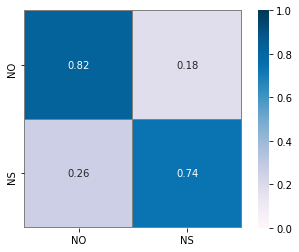

In [105]:
cmx = confusion_matrix(y, predicted, labels=clf.classes_)
cmx_norm = cmx / cmx.sum(axis=1)[:, np.newaxis]
cmx_df = pd.DataFrame(cmx_norm, index=clf.classes_, columns=clf.classes_)
sns.heatmap(cmx_df, square=True, cmap='PuBu', annot=True, linewidths=0.1, linecolor='gray', vmin=0, vmax=1)

(<Figure size 3024x432 with 1 Axes>, <AxesSubplot:>)

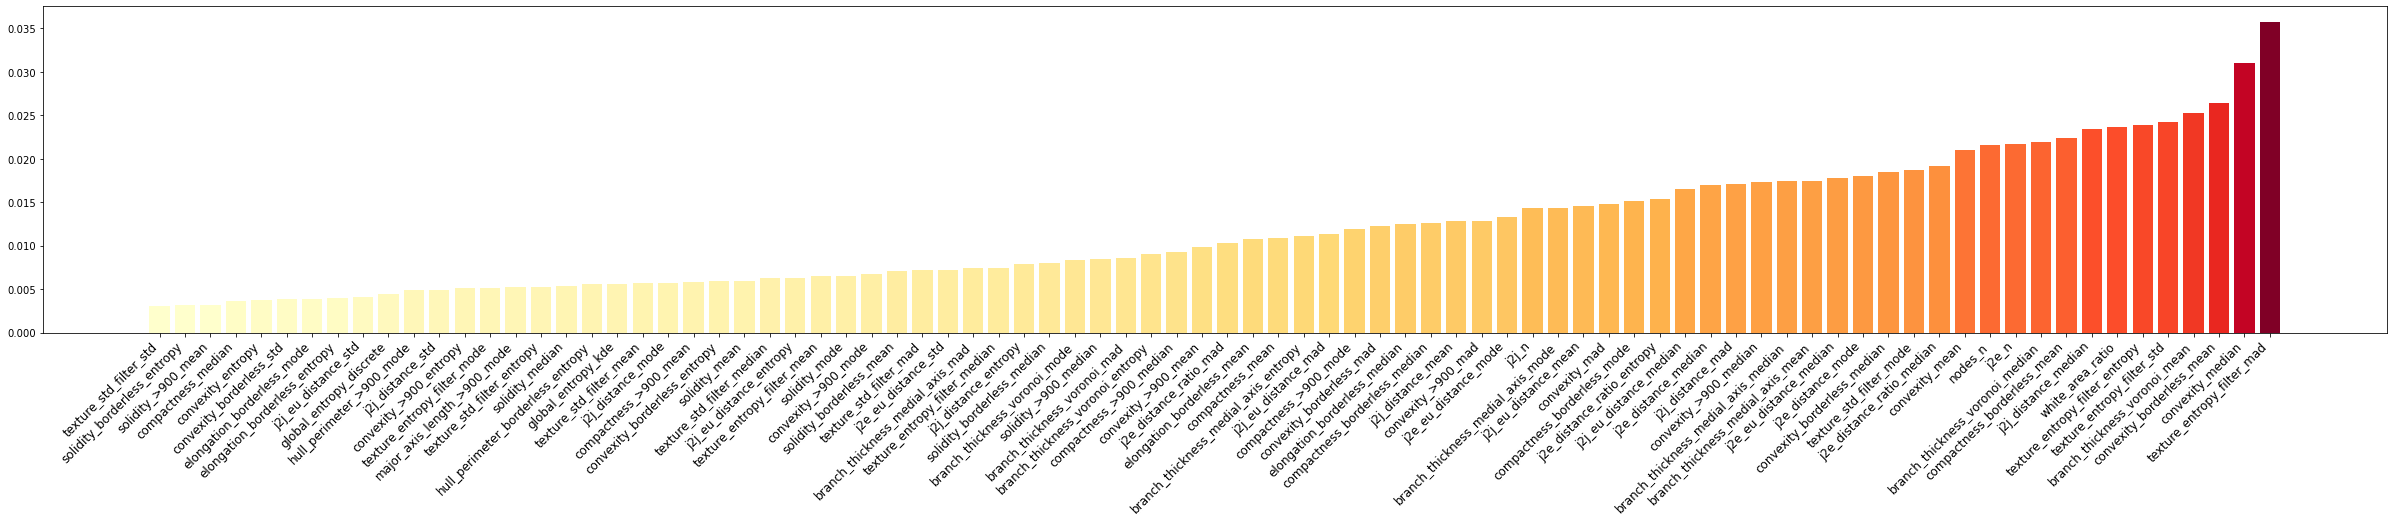

In [106]:
plot_ft_importance(clf, X.columns)

In [ ]:
Exclude small ones for nuclei_blobs_ratio
3 analysis: all blobs, borderless, no small ones

In [ ]:
utils.